In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import poppy
import astropy.units as u
import logging
logging.basicConfig(level=logging.DEBUG)
from astropy.io import fits
from astropy.modeling import models, fitting
import tifffile
import numpy as np
import matplotlib.colors as mcolors
from astropy.stats import sigma_clip
logging.getLogger().setLevel(logging.INFO)
import photutils
import time
import datetime as dt
from numpy.linalg import lstsq
import os
from poppy.zernike import zernike_basis
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import re

# Colormap
dark_yellow = [ '#003f5c', '#2f4b7c', '#665191', '#a05195', '#d45087', '#f95d6a', '#ff7c43', '#ffa600']
custom_cmap = mcolors.LinearSegmentedColormap.from_list("DarkYellow", dark_yellow)
gradient = np.linspace(0, 1, 256).reshape(1, -1)

In [2]:

file = (r"C:\Users\buonc\OneDrive - Alma Mater Studiorum Università di Bologna\Documents\Astrophysics and Cosmology\TESI\dati_WFS\febbraio\Seginus")


# Esempio

In [3]:
import zern.zern_core as zern   # import the main library

# import logging
import numpy as np
from numpy.random import RandomState
import matplotlib.pyplot as plt
plt.rc('font', family='serif')
plt.rc('text', usetex=False)
cmap = 'jet'

# Parameters
N = 1024      # Number of pixels
N_zern = 50
rho_max = 1.0
randgen = RandomState(12345)  # random seed
# [0] Construct the coordinates and the aperture mask - simple circ
x = np.linspace(-rho_max, rho_max, N)
xx, yy = np.meshgrid(x, x)
rho = np.sqrt(xx ** 2 + yy ** 2)
theta = np.arctan2(xx, yy)
aperture_mask = rho <= rho_max
rho, theta = rho[aperture_mask], theta[aperture_mask]
fig, ax = plt.subplots(1, 1)
img_mask = ax.imshow(aperture_mask, extent=[-rho_max, rho_max, -rho_max, rho_max], cmap="plasma")
ax.set_title(r"Simple aperture mask to calculate Zernike Polynomials")
plt.show()

z = zern.Zernike(mask=aperture_mask)
z.create_model_matrix(rho, theta, n_zernike=N_zern, mode='Jacobi', normalize_noll=False)

Np, Nz = z.model_matrix_flat.shape
print(f"Zernike class holds a model matrix of shape ({Np}, {Nz})")
print(f"Np = {Np} is the number of non-zero entries in our aperture")
print(f"Nz = {Nz} is the total number of Zernike polynomials modelled!!")

coef = randgen.normal(size=N_zern) / N_zern
phase_map = z.get_zernike(coef)
fig, ax = plt.subplots(1, 1)
MAX = max(np.max(phase_map), -np.min(phase_map))
img = ax.imshow(phase_map, cmap=cmap, vmin=-MAX, vmax=MAX)
plt.colorbar(img)
plt.show()
# z.N_total

z.create_model_matrix(rho, theta, n_zernike=N_zern, mode='Standard', normalize_noll=False)
map1 = z.get_zernike(coef)
z.create_model_matrix(rho, theta, n_zernike=N_zern, mode='Jacobi', normalize_noll=False)
map2 = z.get_zernike(coef)

fig, axes = plt.subplots(1, 2, figsize=(10, 6))
ax1, ax2 = axes
ax1.imshow(map1, cmap=cmap)
ax2.imshow(map2, cmap=cmap)
ax1.set_title(r"Zernike.Standard")
ax2.set_title(r"Zernike.Jacobi")
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

H = zern.invert_model_matrix(z.model_matrix_flat, z.mask)
p = 4
fig, axes = plt.subplots(p, p, figsize=(12, 12))

# Populate a list with the pairs of (n, m) that the Zernike class will use
index_nm = []
r_max = zern.get_limit_index((p+1)**2)
for n in range(r_max):  # Loop over the Zernike index
    for m in np.arange(-n, n + 1, 2):
        index_nm.append([n, m])

# Show the model matrix entries and their associated orders (n,m)
k = 0
for i in range(p):
    for j in range(p):
        _n, _m = index_nm[k]
        ax = axes.flatten()[k]
        img = ax.imshow(H[:, :, k], cmap='jet')
        ax.set_title(f"H({k}) -> Z(n={_n}, m={_m})")
        k += 1

for ax in axes.flatten():
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

n, m = 2, 0
mode = "Jacobi"

z_flat = z.Z_nm(n, m, rho, theta, False, mode)
z_map = zern.invert_mask(z_flat, z.mask)       # Not that we need to unflatten the

fig, ax = plt.subplots(1, 1)
extents = [-rho_max, rho_max, -rho_max, rho_max]
img = ax.imshow(z_map, cmap='jet', extent=extents, vmin=-1, vmax=1)
ax.set_title(r"Zernike $Z_{%d, %d}$" % (n, m))

cbar = plt.colorbar(img)
# img.set_clim(v_min, v_max)
plt.show()

noll = True
z_noll = zern.Zernike(mask=aperture_mask)
z_noll.create_model_matrix(rho, theta, n_zernike=N_zern, mode='Jacobi', normalize_noll=noll)
rms = [np.std(z_noll.model_matrix_flat[:, k]) for k in range(z.N_total)]

fig, ax = plt.subplots(1, 1)
ax.scatter(range(z.N_total), rms)
ax.set_ylim([0.99, 1.01])
ax.grid(True)
ax.set_xlabel("Zernike polynomial $Z_k$")
ax.set_ylabel("RMS wavefront [ ]")
plt.show()

r = np.linspace(0., 1., N)

z_stability = zern.Zernike(mask=aperture_mask)
n = 44
m = 0

r_nm_std = z_stability.R_nm(n, m, r)   # Using 'Standard' recurrence

fig, ax = plt.subplots(1, 1)
ax.plot(r, r_nm_std)
ax.set_xlim([0.8, 1.0])
ax.grid(True)
ax.set_title("Numerical stability issues start to show up for the 'Standard' recurrence")
ax.set_xlabel(r"Radial coordinate $\rho$ []")
ax.set_ylabel(r"Radial Zernike $Z_{n,m}(\rho)$ []")

r_nm_std = z_stability.R_nm(n, m, r)
r_nm_jac = z_stability.R_nm_Jacobi(n, m, r)
err = r_nm_std - r_nm_jac

fig, ax = plt.subplots(1, 1)
ax.plot(r, r_nm_jac, label='Jacobi', c='k')
ax.scatter(r, r_nm_std, label='Standard', c='r', s=5)
ax.set_xlim([0.8, 1.0])
ax.legend(loc=2, title='Zernike recurrence')
ax.set_title("Using mode='Jacobi' maintains numerical stability even at high radial order", fontsize=10)
ax.set_xlabel(r"Radial coordinate $\rho$ []")
ax.set_ylabel(r"Radial Zernike $Z_{n,m}(\rho)$ []")
ax.grid(True)

N_zern = 100
coef = randgen.normal(size=N_zern) / N_zern

z_ls = zern.Zernike(mask=aperture_mask)
z_ls.create_model_matrix(rho, theta, n_zernike=N_zern, mode='Jacobi', normalize_noll=True)

phase_map = z_ls.get_zernike(coef)

fig, ax = plt.subplots(1, 1)
img = ax.imshow(phase_map, cmap='jet')
plt.colorbar(img)
plt.show()

coef1 = randgen.normal(size=N_zern) / N_zern
coef2 = randgen.normal(size=N_zern) / N_zern

map1 = z_ls.get_zernike(coef1)
map2 = z_ls.get_zernike(coef2)
total_map = (map1 + map2)

plt.figure()
plt.imshow(total_map, cmap=cmap)
plt.show()

flat_phase_map = total_map[z_ls.mask]
# Construct the Least-Squares problem
H_f = z_ls.model_matrix_flat
y = np.dot(H_f.T, flat_phase_map)
N = np.dot(H_f.T, H_f)
invN = np.linalg.inv(N)
fit_result_coef = np.dot(invN, y)
fit_map = z_ls.get_zernike(fit_result_coef)
error_map = total_map - fit_map
E_MAX = max(error_map.max(), -error_map.min())

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 5))
img1 = ax1.imshow(total_map, cmap=cmap)
cb1 = plt.colorbar(img1, ax=ax1, fraction=0.046, pad=0.04)
ax1.set_title(r"Original wavefront $\Phi=\phi_1 + \phi_2$")
img2 = ax2.imshow(fit_map, cmap=cmap)
cb2 = plt.colorbar(img2, ax=ax2, fraction=0.046, pad=0.04)
ax2.set_title(r"Least Squares fit $\Psi=(H_t \cdot H)^{-1}(H_t\cdot \Phi)$")
img3 = ax3.imshow(error_map, cmap='coolwarm', vmin=-E_MAX, vmax=E_MAX)
cb3 = plt.colorbar(img3, ax=ax3, fraction=0.046, pad=0.04)
ax3.set_title(r"Error fit")

for ax in [ax1, ax2, ax3]:
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

ModuleNotFoundError: No module named 'zern.zern_core'

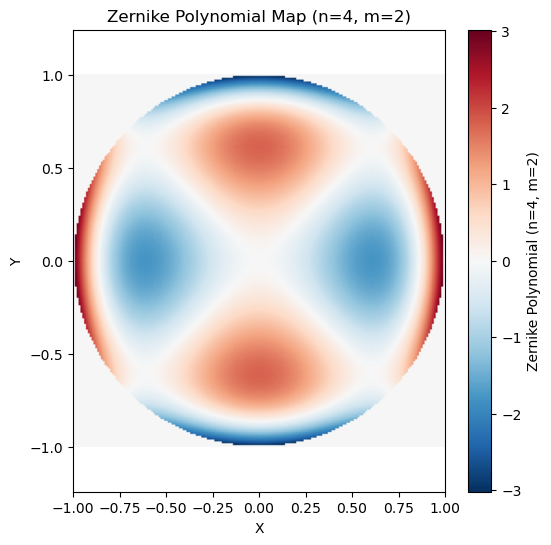

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import poppy

# Create a 2D grid of points in the unit disk
grid_size = 200
x = np.linspace(-1, 1, grid_size)
y = np.linspace(-1, 1, grid_size)
X, Y = np.meshgrid(x, y)

# Convert to polar coordinates
R = np.sqrt(X**2 + Y**2)
Theta = np.arctan2(Y, X)

# Mask points outside the unit disk
mask = R <= 1

# Initialize Zernike array with zeros
Z = np.zeros_like(R)

# Compute Zernike polynomial only inside the unit disk, pass both rho and theta arrays
Z[mask] = poppy.zernike.zernike(4, 2, rho=R[mask], theta=Theta[mask])

# Plotting
plt.figure(figsize=(6, 6))
plt.imshow(Z, extent=(-1, 1, -1, 1), cmap='RdBu_r')
plt.colorbar(label='Zernike Polynomial (n=4, m=2)')
plt.title('Zernike Polynomial Map (n=4, m=2)')
plt.xlabel('X')
plt.ylabel('Y')
plt.axis('equal')
plt.show()



x_coords length: 74
wavefront_data shape: (45, 74)
Mode 1: -3.368921 
Mode 2: 54.539963 
Mode 3: -44.964800 
Mode 4: -1.046972 
Mode 5: -0.190705 
Mode 6: -1.026467 


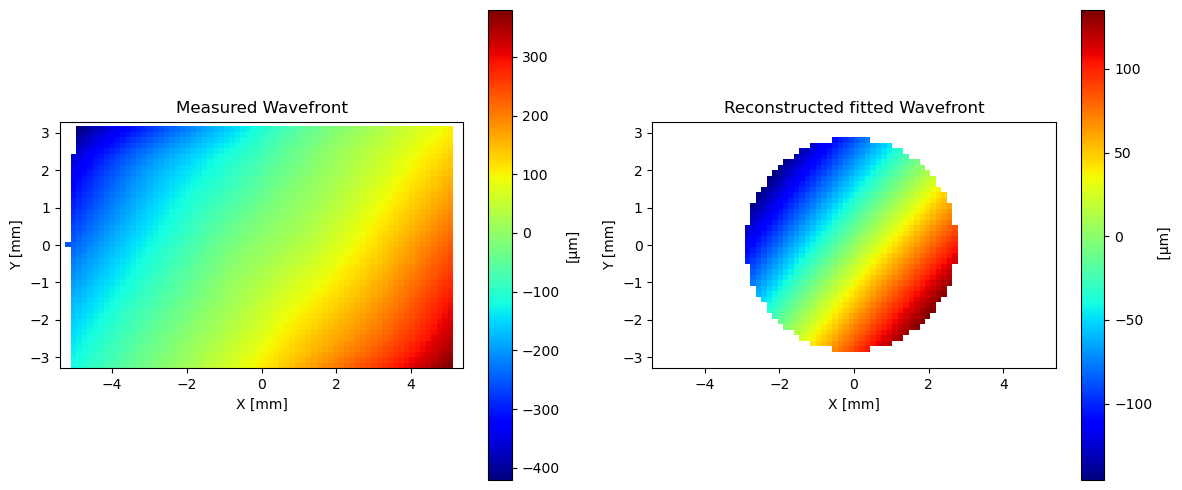

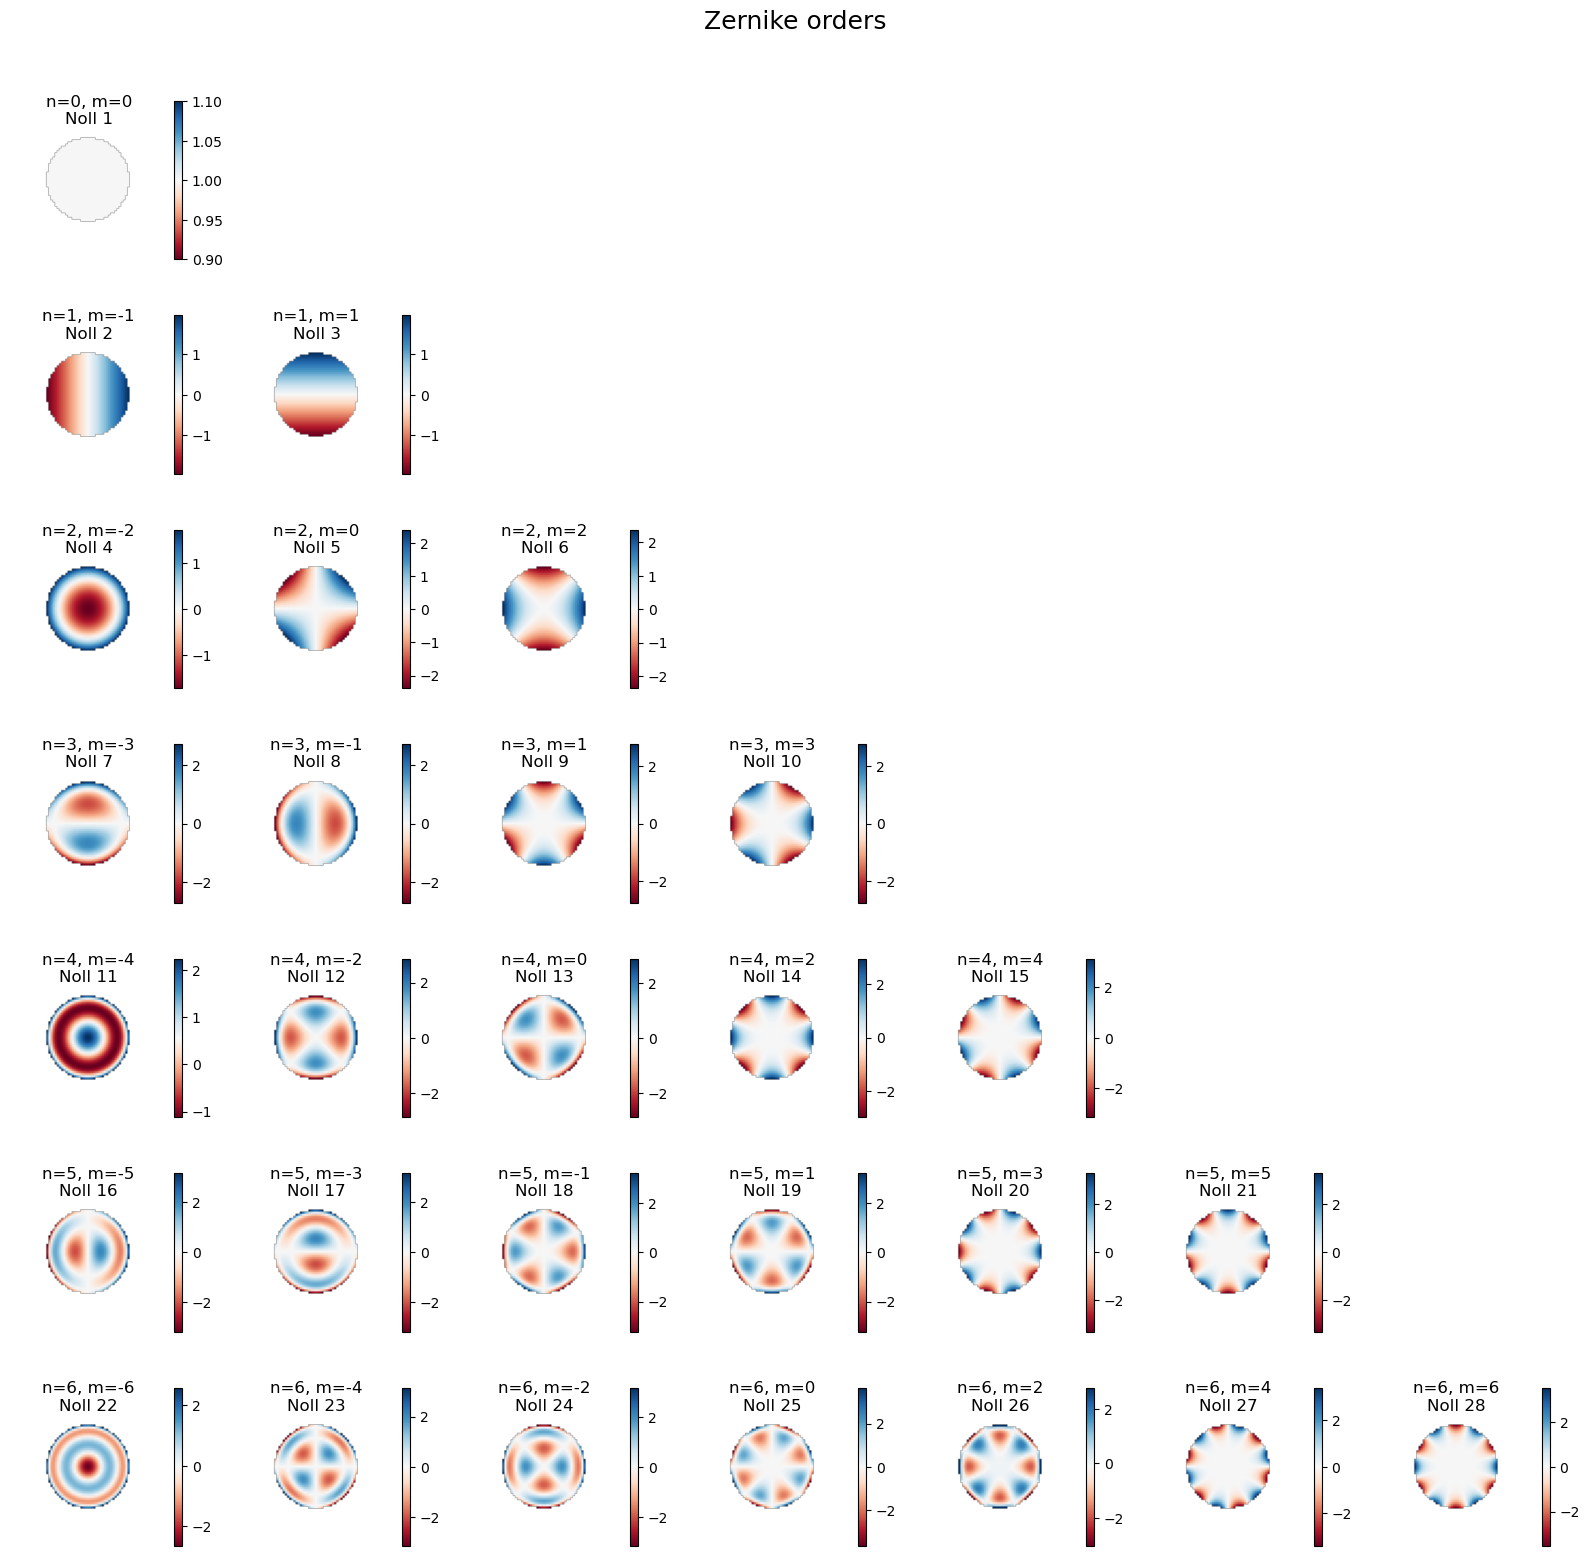

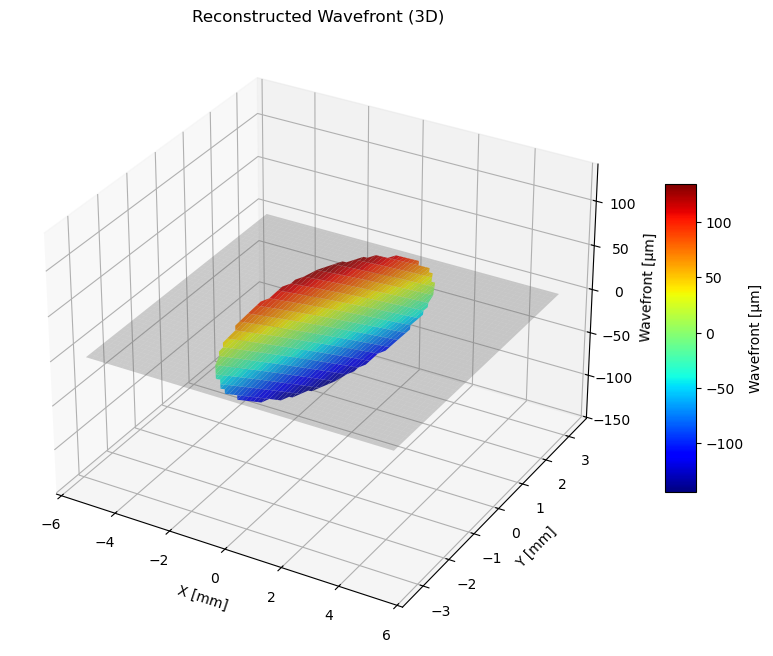

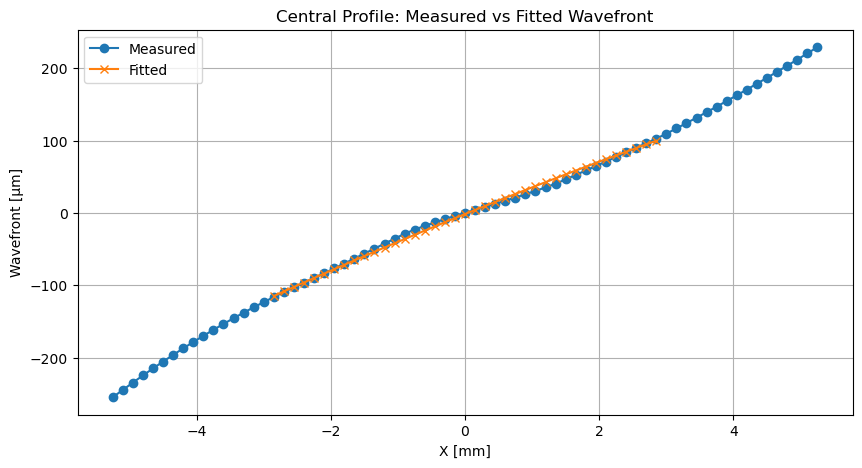

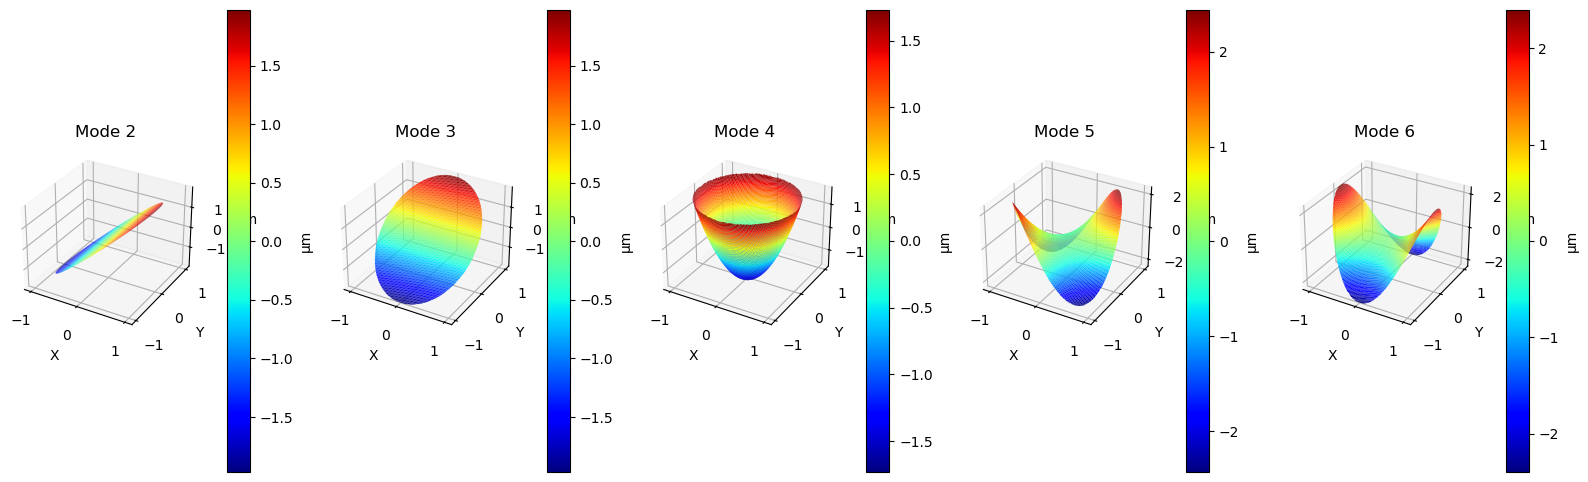

In [10]:
from mpl_toolkits.mplot3d import Axes3D


def noll_to_zernike(j):
    """
    Convert Noll index to (n, m) Zernike indices.
    Noll index j starts from 1.
    Returns (n, m) where n is radial order and m is azimuthal frequency.
    """
    n = 0
    j1 = j - 1
    while j1 >= n + 1:
        n += 1
        j1 -= n
    m = (-n) + 2 * j1
    return n, m


def parse_wavefront_grid(filename):
    with open(filename, 'r', encoding='latin-1') as f:
        lines = f.readlines()
    
    x_coords_line = None
    for i, line in enumerate(lines):
        if line.strip().startswith("y / x [mm]"):
            x_coords_line = i
            break
    
    if x_coords_line is None:
        raise ValueError("X coordinates line not found")
    
    # Extract x coords: keep all, converting invalid to NaN if needed
    x_coords_str = lines[x_coords_line].split(",")[1:]
    x_coords = []
    for x in x_coords_str:
        x_clean = x.strip()
        try:
            x_coords.append(float(x_clean))
        except:
            x_coords.append(np.nan)  # fill invalid with nan
    
    y_coords = []
    wavefront_data = []
    for line in lines[x_coords_line+1:]:
        if line.strip() == "":
            continue
        parts = line.split(",")
        if len(parts) < 2:
            continue
        y_str = parts[0].strip()
        try:
            y = float(y_str)
        except:
            continue
        
        vals = []
        # Keep all columns aligned with x_coords
        for v in parts[1:]:
            v_clean = v.strip()
            try:
                vals.append(float(v_clean))
            except:
                vals.append(np.nan)
        
        y_coords.append(y)
        wavefront_data.append(vals)
    
    wf_array = np.array(wavefront_data)
    y_coords = np.array(y_coords)
    x_coords = np.array(x_coords)

    print(f"x_coords length: {len(x_coords)}")
    print(f"wavefront_data shape: {wf_array.shape}")

    if wf_array.shape[1] != len(x_coords):
        raise ValueError("Mismatch between wavefront columns and x coordinates")

    return x_coords, y_coords, wf_array




def fit_zernikes(x_coords, y_coords, wavefront_data, pupil_diameter, max_mode):  # maxmode=15
    # Normalize to unit pupil centered at 
    X_norm = x_coords / (pupil_diameter / 2)
    Y_norm = y_coords / (pupil_diameter / 2)

    X_mesh, Y_mesh = np.meshgrid(X_norm, Y_norm)
    R = np.sqrt(X_mesh**2 + Y_mesh**2)
    Theta = np.arctan2(Y_mesh, X_mesh)

    mask = R <= 1
    wf_masked = wavefront_data[mask]


    basis_stack = zernike_basis(nterms=max_mode, rho=R, theta=Theta)

    Z_mat = np.vstack([basis_stack[j][mask] for j in range(max_mode)]).T

    # Fit coefficients with least squares
    coeffs, _, _, _ = np.linalg.lstsq(Z_mat, wf_masked, rcond=None)

    # fitted wavefront
    wf_fit = np.full_like(wavefront_data, np.nan)
    fit_vals = np.sum([coeffs[j] * basis_stack[j][mask] for j in range(max_mode)], axis=0)
    wf_fit[mask] = fit_vals

    return coeffs, wf_fit



def plot_wavefronts(x_coords, y_coords, wavefront_data, wavefront_fit):
    extent = [
    np.nanmin(x_coords),
    np.nanmax(x_coords),
    np.nanmin(y_coords),
    np.nanmax(y_coords),
]

    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    im0 = axs[0].imshow(wavefront_data, extent=extent, origin='upper', cmap='jet')
    axs[0].set_title('Measured Wavefront')
    axs[0].set_xlabel('X [mm]')
    axs[0].set_ylabel('Y [mm]')
    plt.colorbar(im0, ax=axs[0], label='[μm]')

    im1 = axs[1].imshow(wavefront_fit, extent=extent, origin='upper', cmap='jet')
    axs[1].set_title('Reconstructed fitted Wavefront')
    axs[1].set_xlabel('X [mm]')
    axs[1].set_ylabel('Y [mm]')
    plt.colorbar(im1, ax=axs[1], label=' [μm]')

    plt.tight_layout()
    plt.show()

######################################################################################################
file = (r"C:\Users\buonc\OneDrive - Alma Mater Studiorum Università di Bologna\Documents\Astrophysics and Cosmology\TESI\dati_WFS\febbraio\Seginus")
directory = file
files = [f for f in os.listdir(directory) if f.endswith('.csv')]
if not files:
    raise FileNotFoundError('No CSV files found in directory')

filename = files[9]  # sceglie il file N trovato nella cartella (solo file CSV, per fare riferimento a quelli della cartella ricordare che il conteggio qui inzia da 0)

full_path = os.path.join(directory, filename)
data = pd.read_csv(full_path, encoding='latin1', comment='#', on_bad_lines='skip',skiprows = 100)  # skip lines starting with #
#print(data.head())

filename = full_path  
pupil_diameter = 5.8  # mm
max_mode = 6
#######################################################################################################


x_coords, y_coords, wavefront_data = parse_wavefront_grid(filename)
coeffs, wavefront_fit = fit_zernikes(x_coords, y_coords, wavefront_data, pupil_diameter, max_mode)

for i, c in enumerate(coeffs, 1):
    print(f"Mode {i}: {c:.6f} ")#µm")

plot_wavefronts(x_coords, y_coords, wavefront_data, wavefront_fit)


#  Zernike modes (n=6)
orders = 6
# Number of Zernike modes up to n=6: (n+1)(n+2)/2 = 28
n_modes = (orders + 1) * (orders + 2) // 2

X_norm = x_coords / (pupil_diameter / 2)
Y_norm = y_coords / (pupil_diameter / 2)
X_mesh, Y_mesh = np.meshgrid(X_norm, Y_norm)
R = np.sqrt(X_mesh**2 + Y_mesh**2)
Theta = np.arctan2(Y_mesh, X_mesh)
mask = R <= 1

basis_stack = zernike_basis(nterms=n_modes, rho=R, theta=Theta)

fig, axs = plt.subplots(orders + 1, orders + 1, figsize=(16, 16))
fig.suptitle("Zernike orders", fontsize=18)
for noll in range(1, n_modes + 1):
    n, m = noll_to_zernike(noll)
    row = n
    col = (m + n) // 2
    ax = axs[row, col]
    zern = np.full_like(R, np.nan)
    zern[mask] = basis_stack[noll - 1][mask]
    im = ax.imshow(zern, extent=[np.nanmin(x_coords), np.nanmax(x_coords), np.nanmin(y_coords), np.nanmax(y_coords)],
                   origin='upper', cmap='RdBu')
    ax.set_title(f"n={n}, m={m}\nNoll {noll}")
    ax.axis('off')
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
# Hide unused subplots
for i in range(orders + 1):
    for j in range(orders + 1):
        if axs[i, j].has_data():
            continue
        axs[i, j].axis('off')
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

X, Y = np.meshgrid(x_coords, y_coords)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, wavefront_fit, cmap='jet', edgecolor='none')
ax.set_title('Reconstructed Wavefront (3D)')
ax.set_xlabel('X [mm]')
ax.set_ylabel('Y [mm]')
ax.set_zlabel('Wavefront [μm]')
fig.colorbar(surf, shrink=0.5, aspect=10, label='Wavefront [μm]')

# Add a horizontal plane at z=0
x_plane = np.linspace(np.nanmin(x_coords), np.nanmax(x_coords), 100)
y_plane = np.linspace(np.nanmin(y_coords), np.nanmax(y_coords), 100)
X_plane, Y_plane = np.meshgrid(x_plane, y_plane)
Z_plane = np.zeros_like(X_plane)
ax.plot_surface(X_plane, Y_plane, Z_plane, color='gray', alpha=0.3, edgecolor='none')

plt.show()


mid_y_idx = len(y_coords) // 2
plt.figure(figsize=(10, 5))
plt.plot(x_coords, wavefront_data[mid_y_idx], label='Measured', marker='o')
plt.plot(x_coords, wavefront_fit[mid_y_idx], label='Fitted', marker='x')
plt.xlabel('X [mm]')
plt.ylabel('Wavefront [μm]')
plt.title('Central Profile: Measured vs Fitted Wavefront')
plt.legend()
plt.grid(True)
plt.show()



##################### 3D PLOTS OF ZERNIKE MODES ##########################

#####################################################################
grid_size = 300
modes = [2,3, 4, 5,6]  # Noll indices 
#############################################################
x = np.linspace(-1, 1, grid_size)
y = np.linspace(-1, 1, grid_size)
X, Y = np.meshgrid(x, y)
R = np.sqrt(X**2 + Y**2)
Theta = np.arctan2(Y, X)
mask = R <= 1.0
basis_stack = zernike_basis(nterms=max(modes), rho=R, theta=Theta)


fig = plt.figure(figsize=(16, 8))
for i, mode in enumerate(modes, 1):
    Z = np.full_like(R, np.nan)
    Z[mask] = basis_stack[mode-1][mask]  # nan outside the pupil

    ax = fig.add_subplot(1, len(modes), i, projection='3d')
    # Only plot points inside the pupil
    # The 'mask' argument is not valid for plot_surface; use nan-masked Z instead
    surf = ax.plot_surface(
        X, Y, Z,
        rstride=3, cstride=3,
        cmap='jet',
        linewidth=0, antialiased=True
    )
    ax.set_title(f'Mode {mode}')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('µm')
    ax.set_zlim(np.nanmin(Z), np.nanmax(Z))
    fig.colorbar(surf, ax=ax, shrink=0.6, pad=0.1, label='µm')

plt.tight_layout()
plt.show()

# Wavefront dal file CSV

Found Zernike coefficients: [-104.397, 47.116, 57.991, -0.14, -0.676, -0.849]
Using Zernike coefficients: [-104.397   47.116   57.991   -0.14    -0.676   -0.849]


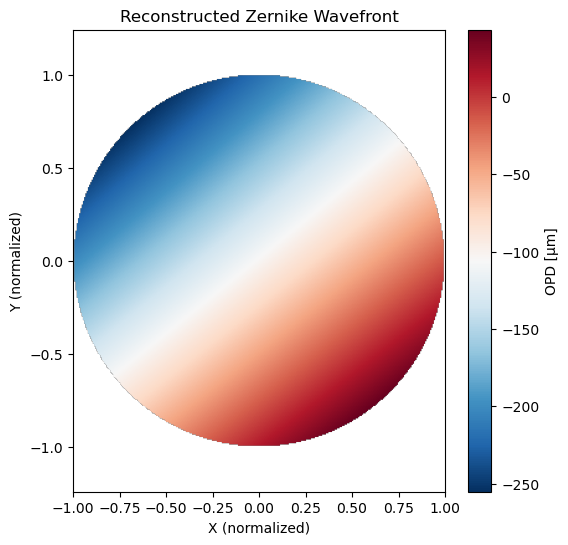

In [ ]:
import re
import numpy as np
import matplotlib.pyplot as plt
from poppy.zernike import zernike_basis

##########################################################################################
directory = file
files = [f for f in os.listdir(directory) if f.endswith('.csv')]
if not files:
    raise FileNotFoundError('No CSV files found in directory')

filename = files[0]  # picks the Nth CSV file 
full_path = os.path.join(directory, filename)
data = pd.read_csv(full_path, encoding='latin1', comment='#', on_bad_lines='skip',skiprows = 100)  # skip lines starting with #
####################################################################################################

def parse_zernike_coeffs(filename, n_modes=15):
    """Read the ‘*** ZERNIKE FIT ***’ section and return the first n_modes coefficients."""
    coeffs = []
    with open(filename, 'r', encoding='latin-1') as f:
        in_section = False
        for line in f:
            if line.strip().startswith('*** ZERNIKE FIT ***'):
                in_section = True
                continue
            if in_section:
                # look for lines like: "   1,     0,     0,      -64.165"
                m = re.match(r'\s*(\d+),\s*-?\d+,\s*-?\d+,\s*([-\d\.eE]+)', line)
                if m:
                    idx = int(m.group(1))
                    coef = float(m.group(2))
                    if idx <= n_modes:
                        coeffs.append(coef)
                # break out once we have all modes or hit next section
                if len(coeffs) >= n_modes:
                    break
    if len(coeffs) < n_modes:
        raise ValueError(f"Found only {len(coeffs)} coefficients, expected {n_modes}")
    print("Found Zernike coefficients:", coeffs)
    return np.array(coeffs)

def reconstruct_from_coeffs(coeffs, grid_size=300):
    
    x = np.linspace(-1, 1, grid_size)
    y = np.linspace(-1, 1, grid_size)
    X, Y = np.meshgrid(x, y)
    R = np.sqrt(X**2 + Y**2)
    Theta = np.arctan2(Y, X)
    mask = R <= 1.0

    # get all modes up to len(coeffs)
    basis = zernike_basis(nterms=len(coeffs), rho=R, theta=Theta)

    # sum up weighted modes
    W = np.zeros_like(R)
    for j, c in enumerate(coeffs):
        W += c * basis[j]
    W[~mask] = np.nan
    return x, y, W

def plot_wavefront(x, y, W, title='Reconstructed Zernike Wavefront'):
    plt.figure(figsize=(6,6))
    plt.imshow(W, extent=[x.min(), x.max(), y.min(), y.max()],
               origin='upper', cmap='RdBu_r')
    plt.colorbar(label='OPD [µm]')
    plt.title(title)
    plt.xlabel('X (normalized)')
    plt.ylabel('Y (normalized)')
    plt.axis('equal')
    plt.show()


filename = full_path
n_modes = 6 
coeffs = parse_zernike_coeffs(filename, n_modes=n_modes)
print("Using Zernike coefficients:", coeffs)
x, y, W = reconstruct_from_coeffs(coeffs, grid_size=300)
plot_wavefront(x, y, W)


x_coords length: 74
wavefront_data shape: (45, 74)
Mode 1: -3.368921 
Mode 2: 54.539963 
Mode 3: -44.964800 
Mode 4: -1.046972 
Mode 5: -0.190705 
Mode 6: -1.026467 


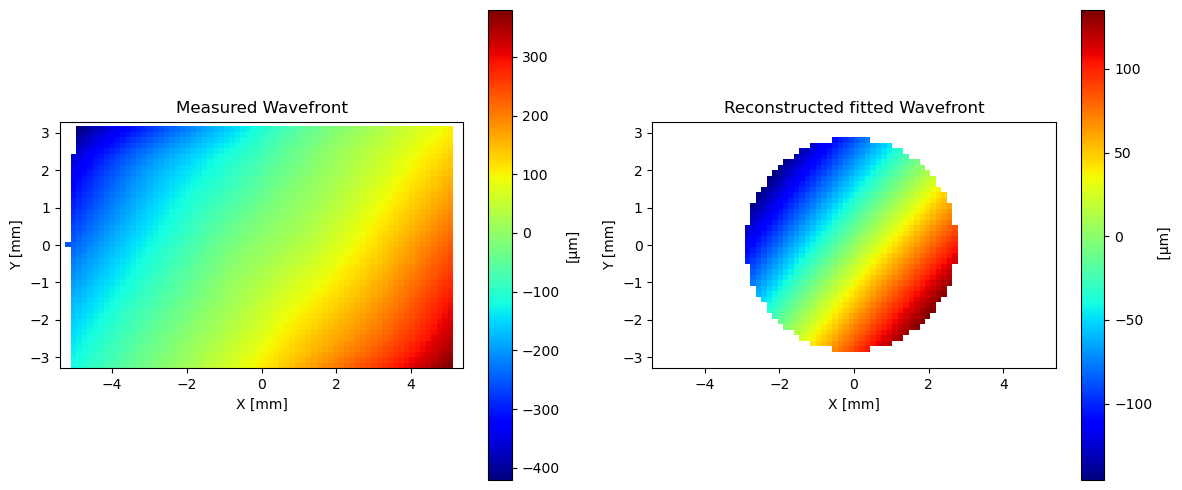

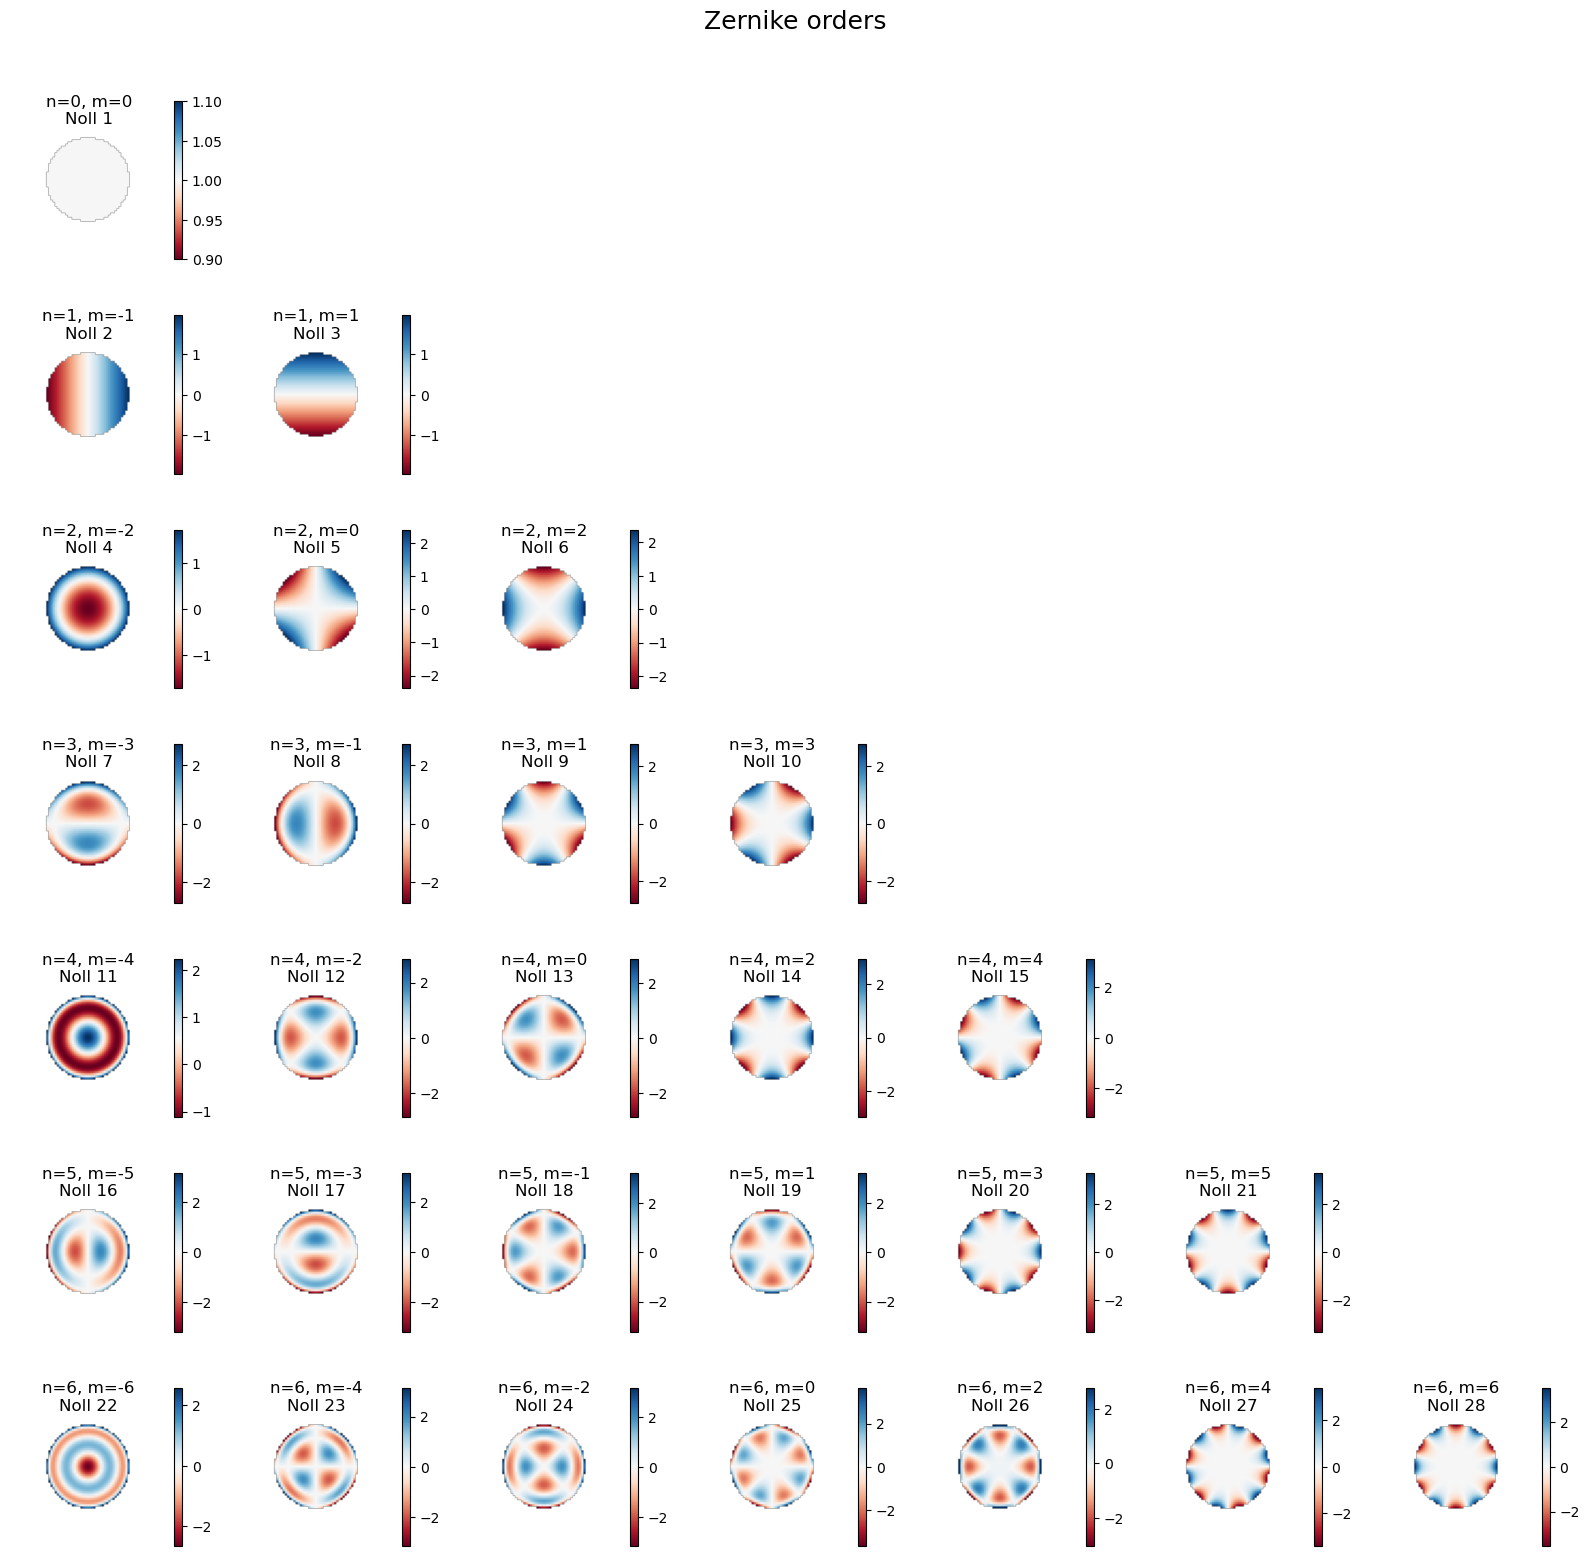

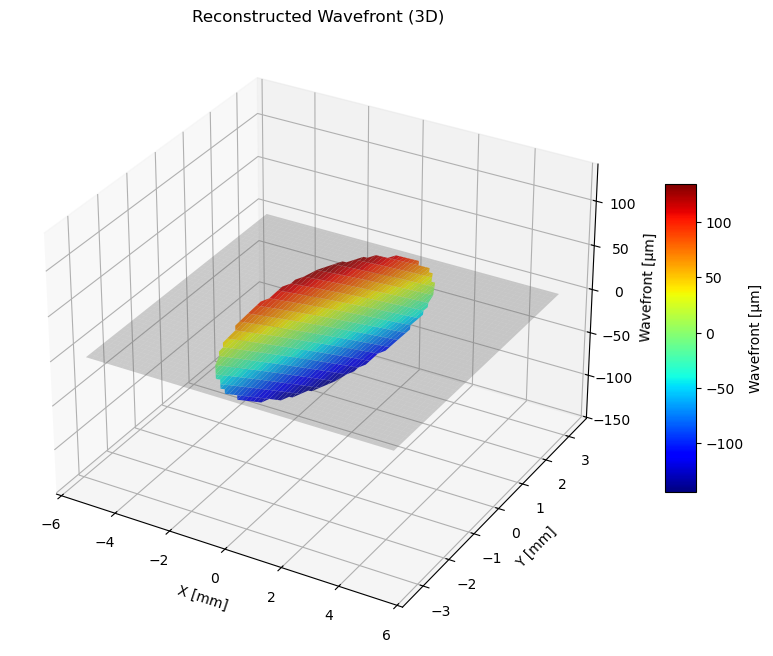

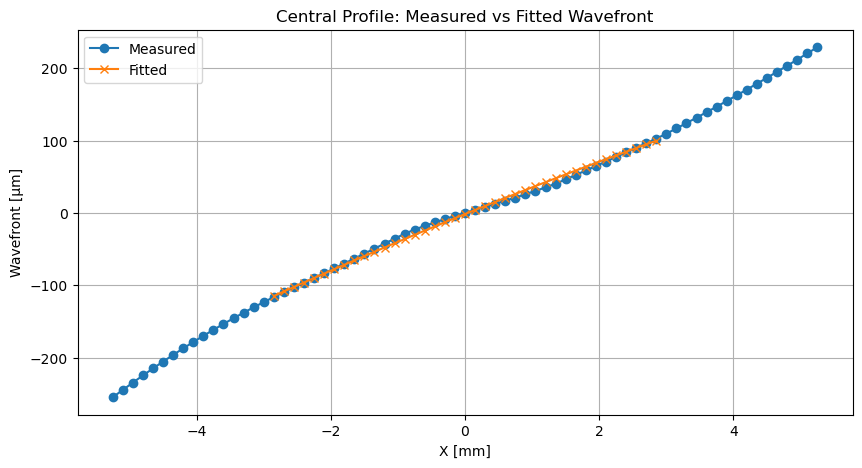

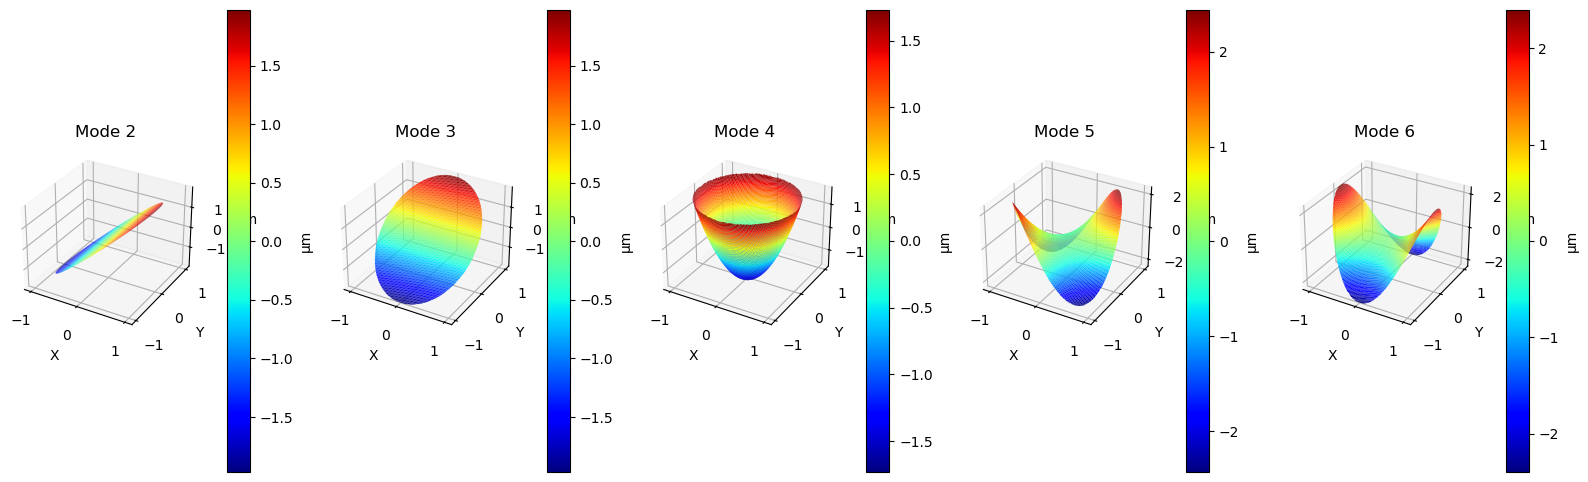

RMS difference between your fit and sensor's Zernike fit: 147.151 µm


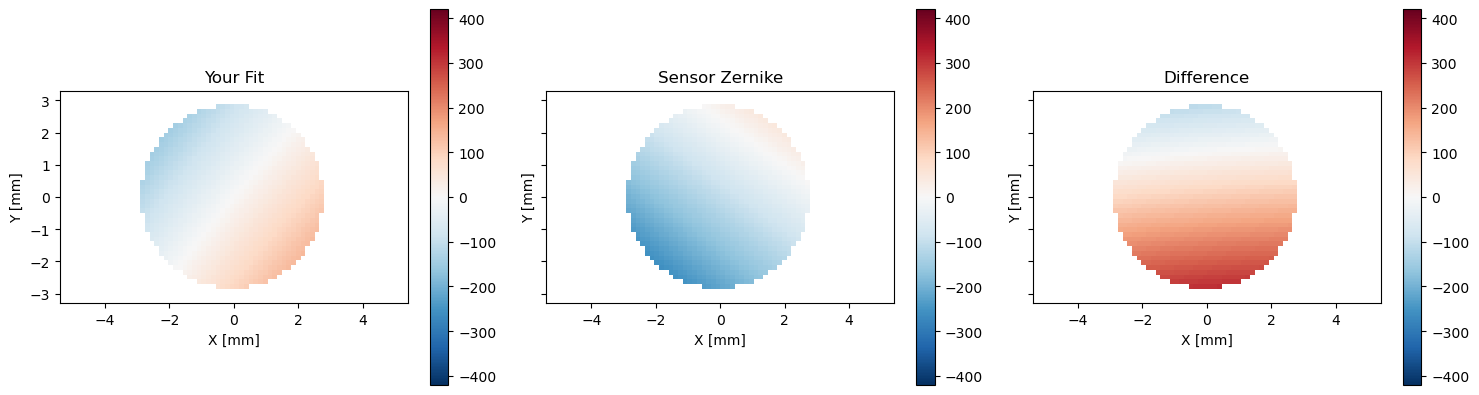

In [ ]:
import re
from mpl_toolkits.mplot3d import Axes3D


def noll_to_zernike(j):
    """
    Convert Noll index to (n, m) Zernike indices.
    Noll index j starts from 1.
    Returns (n, m) where n is radial order and m is azimuthal frequency.
    """
    n = 0
    j1 = j - 1
    while j1 >= n + 1:
        n += 1
        j1 -= n
    m = (-n) + 2 * j1
    return n, m


def parse_wavefront_grid(filename):
    with open(filename, 'r', encoding='latin-1') as f:
        lines = f.readlines()
    
    x_coords_line = None
    for i, line in enumerate(lines):
        if line.strip().startswith("y / x [mm]"):
            x_coords_line = i
            break
    
    if x_coords_line is None:
        raise ValueError("X coordinates line not found")
    
    # Extract x coords
    x_coords_str = lines[x_coords_line].split(",")[1:]
    x_coords = []
    for x in x_coords_str:
        x_clean = x.strip()
        try:
            x_coords.append(float(x_clean))
        except:
            x_coords.append(np.nan) 
    
    y_coords = []
    wavefront_data = []
    for line in lines[x_coords_line+1:]:
        if line.strip() == "":
            continue
        parts = line.split(",")
        if len(parts) < 2:
            continue
        y_str = parts[0].strip()
        try:
            y = float(y_str)
        except:
            continue
        
        vals = []
        # Keep all columns aligned with x_coords
        for v in parts[1:]:
            v_clean = v.strip()
            try:
                vals.append(float(v_clean))
            except:
                vals.append(np.nan)
        
        y_coords.append(y)
        wavefront_data.append(vals)
    
    wf_array = np.array(wavefront_data)
    y_coords = np.array(y_coords)
    x_coords = np.array(x_coords)

    print(f"x_coords length: {len(x_coords)}")
    print(f"wavefront_data shape: {wf_array.shape}")

    if wf_array.shape[1] != len(x_coords):
        raise ValueError("Mismatch between wavefront columns and x coordinates")

    return x_coords, y_coords, wf_array




def fit_zernikes(x_coords, y_coords, wavefront_data, pupil_diameter, max_mode):  # maxmode=15
    # Normalize to unit pupil centered at 
    X_norm = x_coords / (pupil_diameter / 2)
    Y_norm = y_coords / (pupil_diameter / 2)

    X_mesh, Y_mesh = np.meshgrid(X_norm, Y_norm)
    R = np.sqrt(X_mesh**2 + Y_mesh**2)
    Theta = np.arctan2(Y_mesh, X_mesh)

    mask = R <= 1
    wf_masked = wavefront_data[mask]


    basis_stack = zernike_basis(nterms=max_mode, rho=R, theta=Theta)

    Z_mat = np.vstack([basis_stack[j][mask] for j in range(max_mode)]).T

    # Fit coefficients with least squares
    coeffs, _, _, _ = np.linalg.lstsq(Z_mat, wf_masked, rcond=None)

    # fitted wavefront
    wf_fit = np.full_like(wavefront_data, np.nan)
    fit_vals = np.sum([coeffs[j] * basis_stack[j][mask] for j in range(max_mode)], axis=0)
    wf_fit[mask] = fit_vals

    return coeffs, wf_fit



def plot_wavefronts(x_coords, y_coords, wavefront_data, wavefront_fit):
    extent = [
    np.nanmin(x_coords),
    np.nanmax(x_coords),
    np.nanmin(y_coords),
    np.nanmax(y_coords),
]

    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    im0 = axs[0].imshow(wavefront_data, extent=extent, origin='upper', cmap='jet')
    axs[0].set_title('Measured Wavefront')
    axs[0].set_xlabel('X [mm]')
    axs[0].set_ylabel('Y [mm]')
    plt.colorbar(im0, ax=axs[0], label='[μm]')

    im1 = axs[1].imshow(wavefront_fit, extent=extent, origin='upper', cmap='jet')
    axs[1].set_title('Reconstructed fitted Wavefront')
    axs[1].set_xlabel('X [mm]')
    axs[1].set_ylabel('Y [mm]')
    plt.colorbar(im1, ax=axs[1], label=' [μm]')

    plt.tight_layout()
    plt.show()

######################################################################################################
file = (r"C:\Users\buonc\OneDrive - Alma Mater Studiorum Università di Bologna\Documents\Astrophysics and Cosmology\TESI\dati_WFS\febbraio\Seginus")
directory = file
files = [f for f in os.listdir(directory) if f.endswith('.csv')]
if not files:
    raise FileNotFoundError('No CSV files found in directory')

filename = files[9]  # sceglie il file N trovato nella cartella (solo file CSV, per fare riferimento a quelli della cartella ricordare che il conteggio qui inzia da 0)

full_path = os.path.join(directory, filename)
data = pd.read_csv(full_path, encoding='latin1', comment='#', on_bad_lines='skip',skiprows = 100)  # skip lines starting with #
#print(data.head())

filename = full_path  
pupil_diameter = 5.8  # mm
max_mode = 6
#  Zernike modes (n=6)
orders = 6
#######################################################################################################


x_coords, y_coords, wavefront_data = parse_wavefront_grid(filename)
coeffs, wavefront_fit = fit_zernikes(x_coords, y_coords, wavefront_data, pupil_diameter, max_mode)

for i, c in enumerate(coeffs, 1):
    print(f"Mode {i}: {c:.6f} ")#µm")

plot_wavefronts(x_coords, y_coords, wavefront_data, wavefront_fit)



# Number of Zernike modes up to n=6: (n+1)(n+2)/2 = 28
n_modes = (orders + 1) * (orders + 2) // 2

X_norm = x_coords / (pupil_diameter / 2)
Y_norm = y_coords / (pupil_diameter / 2)
X_mesh, Y_mesh = np.meshgrid(X_norm, Y_norm)
R = np.sqrt(X_mesh**2 + Y_mesh**2)
Theta = np.arctan2(Y_mesh, X_mesh)
mask = R <= 1

basis_stack = zernike_basis(nterms=n_modes, rho=R, theta=Theta)

fig, axs = plt.subplots(orders + 1, orders + 1, figsize=(16, 16))
fig.suptitle("Zernike orders", fontsize=18)
for noll in range(1, n_modes + 1):
    n, m = noll_to_zernike(noll)
    row = n
    col = (m + n) // 2
    ax = axs[row, col]
    zern = np.full_like(R, np.nan)
    zern[mask] = basis_stack[noll - 1][mask]
    im = ax.imshow(zern, extent=[np.nanmin(x_coords), np.nanmax(x_coords), np.nanmin(y_coords), np.nanmax(y_coords)],
                   origin='upper', cmap='RdBu')
    ax.set_title(f"n={n}, m={m}\nNoll {noll}")
    ax.axis('off')
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

for i in range(orders + 1):
    for j in range(orders + 1):
        if axs[i, j].has_data():
            continue
        axs[i, j].axis('off')
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

X, Y = np.meshgrid(x_coords, y_coords)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, wavefront_fit, cmap='jet', edgecolor='none')
ax.set_title('Reconstructed Wavefront (3D)')
ax.set_xlabel('X [mm]')
ax.set_ylabel('Y [mm]')
ax.set_zlabel('Wavefront [μm]')
fig.colorbar(surf, shrink=0.5, aspect=10, label='Wavefront [μm]')
x_plane = np.linspace(np.nanmin(x_coords), np.nanmax(x_coords), 100)
y_plane = np.linspace(np.nanmin(y_coords), np.nanmax(y_coords), 100)
X_plane, Y_plane = np.meshgrid(x_plane, y_plane)
Z_plane = np.zeros_like(X_plane)
ax.plot_surface(X_plane, Y_plane, Z_plane, color='gray', alpha=0.3, edgecolor='none')

plt.show()


mid_y_idx = len(y_coords) // 2
plt.figure(figsize=(10, 5))
plt.plot(x_coords, wavefront_data[mid_y_idx], label='Measured', marker='o')
plt.plot(x_coords, wavefront_fit[mid_y_idx], label='Fitted', marker='x')
plt.xlabel('X [mm]')
plt.ylabel('Wavefront [μm]')
plt.title('Central Profile: Measured vs Fitted Wavefront')
plt.legend()
plt.grid(True)
plt.show()



##################### 3D PLOTS OF ZERNIKE MODES ##########################

#####################################################################
grid_size = 300
modes = [2,3, 4, 5,6]  # Noll indices 
#############################################################
x = np.linspace(-1, 1, grid_size)
y = np.linspace(-1, 1, grid_size)
X, Y = np.meshgrid(x, y)
R = np.sqrt(X**2 + Y**2)
Theta = np.arctan2(Y, X)
mask = R <= 1.0
basis_stack = zernike_basis(nterms=max(modes), rho=R, theta=Theta)


fig = plt.figure(figsize=(16, 8))
for i, mode in enumerate(modes, 1):
    Z = np.full_like(R, np.nan)
    Z[mask] = basis_stack[mode-1][mask]  # nan outside the pupil

    ax = fig.add_subplot(1, len(modes), i, projection='3d')
    # Only plot points inside the pupil
    surf = ax.plot_surface(
        X, Y, Z,
        rstride=3, cstride=3,
        cmap='jet',
        linewidth=0, antialiased=True
    )
    ax.set_title(f'Mode {mode}')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('µm')
    ax.set_zlim(np.nanmin(Z), np.nanmax(Z))
    fig.colorbar(surf, ax=ax, shrink=0.6, pad=0.1, label='µm')

plt.tight_layout()
plt.show()

def parse_zernike_coeffs(filename, n_modes):
    coeffs = []
    with open(filename, 'r', encoding='latin-1') as f:
        in_section = False
        for line in f:
            if line.strip().startswith('*** ZERNIKE FIT ***'):
                in_section = True
                continue
            if in_section:
                m = re.match(r'\s*(\d+),\s*-?\d+,\s*-?\d+,\s*([-\d\.eE]+)', line)
                if m:
                    idx = int(m.group(1))
                    c   = float(m.group(2))
                    if idx <= n_modes:
                        coeffs.append(c)
                if len(coeffs) >= n_modes:
                    break
    if len(coeffs) < n_modes:
        raise RuntimeError(f"Only found {len(coeffs)} coeffs, expected {n_modes}")
    return np.array(coeffs)


sensor_coeffs = parse_zernike_coeffs(filename, max_mode)


X_norm = x_coords / (pupil_diameter / 2)
Y_norm = y_coords / (pupil_diameter / 2)
X_mesh, Y_mesh = np.meshgrid(X_norm, Y_norm)
R = np.sqrt(X_mesh**2 + Y_mesh**2)
Theta = np.arctan2(Y_mesh, X_mesh)
mask = R <= 1


basis_stack = zernike_basis(nterms=max_mode, rho=R, theta=Theta)


wf_sensor = np.zeros_like(R)
for j, c in enumerate(sensor_coeffs):
    wf_sensor += c * basis_stack[j]
wf_sensor[~mask] = np.nan

# RMS difference
diff = wavefront_fit - wf_sensor
rms = np.sqrt(np.nanmean((diff[mask])**2))
print(f"RMS difference between fit and sensor's Zernike fit: {rms:.3f} µm")


extent = [
    np.nanmin(x_coords),
    np.nanmax(x_coords),
    np.nanmin(y_coords),
    np.nanmax(y_coords),
]


fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,5), sharex=True, sharey=True)
for ax, W, title in zip([ax1,ax2,ax3],
                        [wavefront_fit, wf_sensor, diff],
                        ['Fit','Sensor Zernike','Difference']):
    im = ax.imshow(W, extent=extent, origin='upper', cmap='RdBu_r',
                   vmin=-np.nanmax(np.abs(wavefront_data)),
                   vmax= np.nanmax(np.abs(wavefront_data)))
    ax.set_title(title)
    ax.set_xlabel('X [mm]'); ax.set_ylabel('Y [mm]')
    fig.colorbar(im, ax=ax, shrink=0.8)
plt.tight_layout()
plt.show()




# Con zernike_decompose_opd

RMS manual vs measured:           1.61255466859665
RMS builtin decompose_opd vs measured: 2.7934222344981112
RMS sensor CSV vs measured:      133.67073203402103


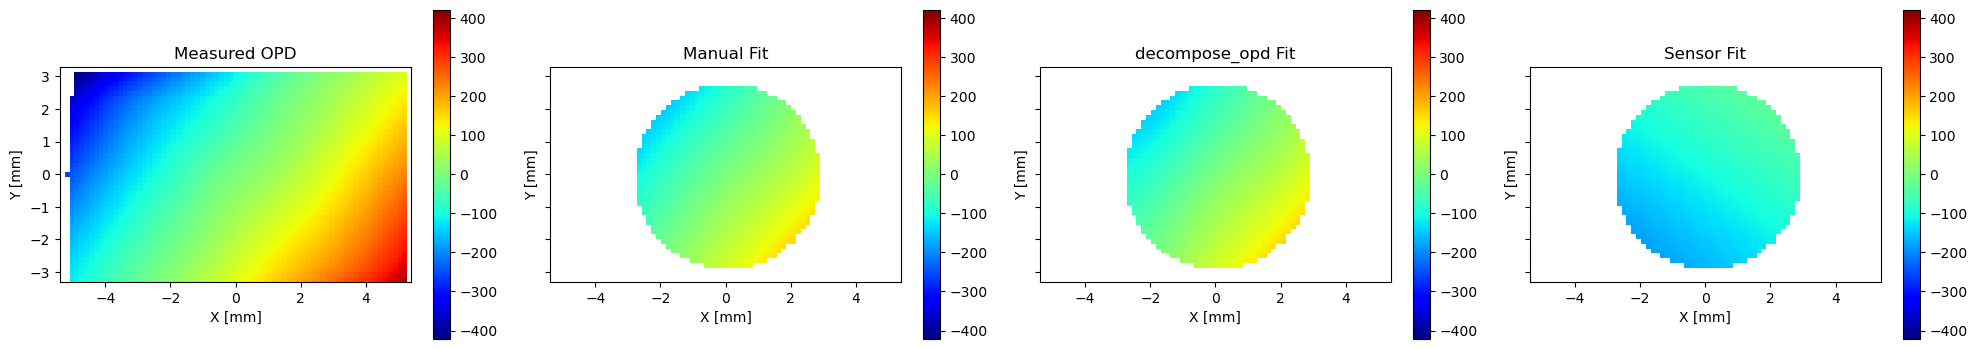

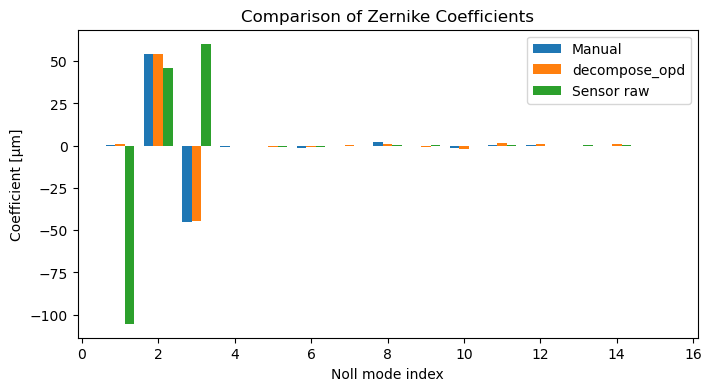

Mode | Manual    | decompose_opd | Sensor raw
   1 |    0.363 |        0.848 |   -105.313
   2 |   54.431 |       54.036 |     45.727
   3 |  -44.909 |      -44.590 |     60.313
   4 |   -0.842 |       -0.025 |      0.034
   5 |   -0.411 |       -0.596 |     -0.704
   6 |   -1.106 |       -0.760 |     -0.929
   7 |   -0.280 |        0.456 |     -0.256
   8 |    2.105 |        1.215 |      0.288
   9 |   -0.140 |       -0.632 |      0.690
  10 |   -1.564 |       -2.217 |     -0.210
  11 |    0.457 |        1.473 |      0.157
  12 |    0.348 |        0.782 |     -0.096
  13 |    0.076 |       -0.185 |      0.239
  14 |   -0.366 |        0.755 |      0.311
  15 |   -0.183 |       -0.226 |     -0.251
Best scale raw→manual: -0.015198903926977675


NameError: name 'wf' is not defined

In [ ]:
import os, re
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import RegularGridInterpolator
from poppy.zernike import zernike_basis, decompose_opd

# —————————————————————————————————————————————————————————————————————
# parse the CSV
# —————————————————————————————————————————————————————————————————————

def parse_pupil_center(filename):
    """Read Pupil Center X/Y [mm] from the PUPIL section."""
    cx = cy = None
    with open(filename, 'r', encoding='latin-1') as f:
        for line in f:
            if 'Pupil Center X [mm]' in line:
                cx = float(line.split(',')[1])
            if 'Pupil Center Y [mm]' in line:
                cy = float(line.split(',')[1])
            if cx is not None and cy is not None:
                break
    if cx is None or cy is None:
        raise RuntimeError("Could not find pupil center in file")
    return cx, cy

def parse_wavefront_grid(filename):
    """Parse the 2D OPD grid (in µm) and x/y coords (in mm)."""
    with open(filename, 'r', encoding='latin-1') as f:
        lines = f.readlines()

    # find the "y / x [mm]" header
    idx = next(i for i,l in enumerate(lines) if l.strip().startswith('y / x [mm]'))

    # X coords
    raw_x = lines[idx].split(',')[1:]
    x = np.array([float(t) for t in raw_x if t.strip() and t.strip().lower()!='nan'])

    # Data rows
    y = []
    rows = []
    for l in lines[idx+1:]:
        if not l.strip() or l.startswith('***'):
            break
        parts = l.split(',')
        yt = parts[0].strip()
        if not yt or yt.lower()=='nan':
            continue
        y.append(float(yt))
        row = []
        for v in parts[1:]:
            vc = v.strip()
            row.append(np.nan if (not vc or vc.lower()=='nan') else float(vc))
        # pad/truncate
        if len(row) < len(x):
            row += [np.nan]*(len(x)-len(row))
        else:
            row = row[:len(x)]
        rows.append(row)

    return x, np.array(y), np.array(rows)

def parse_zernike_coeffs(filename, n_modes):
    """Extract the first n_modes Zernike coefficients (Noll order) from the CSV."""
    coeffs = []
    with open(filename, 'r', encoding='latin-1') as f:
        in_zfit = False
        for line in f:
            if line.strip().startswith('*** ZERNIKE FIT ***'):
                in_zfit = True
                continue
            if in_zfit:
                m = re.match(r'\s*(\d+),\s*-?\d+,\s*-?\d+,\s*([-\d\.eE]+)', line)
                if m:
                    idx, c = int(m.group(1)), float(m.group(2))
                    if idx <= n_modes:
                        coeffs.append(c)
                if len(coeffs) >= n_modes:
                    break
    if len(coeffs) < n_modes:
        raise RuntimeError(f"Found only {len(coeffs)} coeffs, expected {n_modes}")
    return np.array(coeffs)

# —————————————————————————————————————————————————————————————————————
# Zernike fits
# —————————————————————————————————————————————————————————————————————

def manual_fit_zernikes(x, y, wf, pupil_d, n_modes, cx, cy):
    Xn = (x - cx)/(pupil_d/2)
    Yn = (y - cy)/(pupil_d/2)
    Xm, Ym = np.meshgrid(Xn, Yn)
    R = np.sqrt(Xm**2 + Ym**2)
    Th = np.arctan2(Ym, Xm)
    mask = R <= 1

    basis = zernike_basis(nterms=n_modes, rho=R, theta=Th)
    Zmat = np.vstack([basis[j][mask] for j in range(n_modes)]).T
    wf_vec = wf[mask]
    coeffs, *_ = np.linalg.lstsq(Zmat, wf_vec, rcond=None)

    wf_fit = np.full_like(wf, np.nan)
    wf_fit[mask] = sum(coeffs[j]*basis[j][mask] for j in range(n_modes))
    return coeffs, wf_fit, R, Th, mask

def builtin_fit_zernikes(wf, mask, n_modes, R, Th):
    coeffs = decompose_opd(wf, aperture=mask, nterms=n_modes, basis=zernike_basis,
                          rho=R, theta=Th)
    basis = zernike_basis(nterms=n_modes, rho=R, theta=Th)
    wf_fit = np.full_like(wf, np.nan)
    wf_fit[mask] = sum(coeffs[j]*basis[j][mask] for j in range(n_modes))
    return coeffs, wf_fit

def sensor_reconstruct(x, y, pupil_d, cx, cy, sensor_coeffs):
    """Rebuild the sensor’s CSV‐provided Zernike fit on the recentered grid."""
    Xn = (x - cx)/(pupil_d/2)
    Yn = (y - cy)/(pupil_d/2)
    Xm, Ym = np.meshgrid(Xn, Yn)
    R = np.sqrt(Xm**2 + Ym**2)
    Th = np.arctan2(Ym, Xm)
    mask = R <= 1
    basis = zernike_basis(nterms=len(sensor_coeffs), rho=R, theta=Th)
    wf_fit = np.full_like(R, np.nan)
    wf_fit[mask] = sum(sensor_coeffs[j]*basis[j][mask] for j in range(len(sensor_coeffs)))
    return wf_fit, R, mask

# —————————————————————————————————————————————————————————————————————
# Main
# —————————————————————————————————————————————————————————————————————

if __name__=='__main__':
###############################################################################################################
    directory      = (r"C:\Users\buonc\OneDrive - Alma Mater Studiorum Università di Bologna\Documents\Astrophysics and Cosmology\TESI\dati_WFS\febbraio\Seginus")
    files          = [f for f in os.listdir(directory) if f.endswith('.csv')]
    filename       = os.path.join(directory, files[9])
    pupil_diameter = 5.8
    n_modes        = 15
#############################################################################################################################
    # --- parse everything ---
    cx, cy          = parse_pupil_center(filename)
    x_phys, y_phys, W_phys = parse_wavefront_grid(filename)
    sensor_coeffs  = parse_zernike_coeffs(filename, n_modes)

    # --- manual fit ---
    m_coeffs, W_manual, R, Th, mask = manual_fit_zernikes(
        x_phys, y_phys, W_phys,
        pupil_diameter, n_modes, cx, cy
    )

    # --- builtin decompose_opd fit ---
    b_coeffs, W_builtin = builtin_fit_zernikes(
        W_phys, mask, n_modes, R, Th
    )

    # # --- sensor CSV fit ---
    # W_sensor, _, _ = sensor_reconstruct(
    #     x_phys, y_phys, pupil_diameter, cx, cy, sensor_coeffs
    # )
    # --- sensor’s own CSV coefficients, then normalize them to Poppy’s orthonormal basis ---
    raw_coeffs = parse_zernike_coeffs(filename, n_modes)
    poppy_coeffs = []
    for j, c in enumerate(raw_coeffs, start=1):
        n, m = noll_to_zernike(j)
        if m == 0:
            poppy_coeffs.append(c/np.sqrt(n+1))
        else:
            poppy_coeffs.append(c/np.sqrt(2*(n+1)))
    poppy_coeffs = np.array(poppy_coeffs)

# Now reconstruct using the normalized coefficients
    W_sensor, _, _ = sensor_reconstruct(
        x_phys, y_phys, pupil_diameter, cx, cy, poppy_coeffs
    )


    # --- compute RMS inside pupil mask ---
    def rms(A,B): return np.sqrt(np.nanmean((A[mask]-B[mask])**2))
    print("RMS manual vs measured:          ", rms(W_manual, W_phys))
    print("RMS builtin decompose_opd vs measured:", rms(W_builtin, W_phys))
    print("RMS sensor CSV vs measured:     ", rms(W_sensor, W_phys))

    # --- plot measured + all fits side-by-side ---
    extent = [x_phys.min(), x_phys.max(), y_phys.min(), y_phys.max()]
    titles = ['Measured OPD','Manual Fit','decompose_opd Fit','Sensor Fit']
    maps   = [W_phys, W_manual, W_builtin, W_sensor]

    fig, axs = plt.subplots(1,4,figsize=(20,5), sharex=True, sharey=True)
    vlim = np.nanmax(np.abs(W_phys))
    for ax, W, t in zip(axs, maps, titles):
        im = ax.imshow(W, extent=extent, origin='upper',
                       cmap='jet', vmin=-vlim, vmax=vlim)
        ax.set_title(t)
        ax.set_xlabel('X [mm]'); ax.set_ylabel('Y [mm]')
        fig.colorbar(im, ax=ax, shrink=0.7)
    plt.tight_layout()
    plt.show()




modes = np.arange(1, n_modes+1)

plt.figure(figsize=(8,4))
width = 0.25
plt.bar(modes - width, m_coeffs,   width, label='Manual')
plt.bar(modes,         b_coeffs,   width, label='decompose_opd')
plt.bar(modes + width, raw_coeffs, width, label='Sensor raw')
plt.xlabel('Noll mode index')
plt.ylabel('Coefficient [µm]')
plt.legend()
plt.title('Comparison of Zernike Coefficients')
plt.show()
print("Mode | Manual    | decompose_opd | Sensor raw")
for j in range(n_modes):
    print(f"{j+1:4d} | {m_coeffs[j]:8.3f} | {b_coeffs[j]:12.3f} | {raw_coeffs[j]:10.3f}")
    




scale = np.sum(m_coeffs * raw_coeffs) / np.sum(raw_coeffs**2)
print("Best scale raw→manual:", scale)









# Ordered Zernike

RMS decompose_opd vs measured: 2.638 µm
RMS sensor vs measured:        125.065 µm


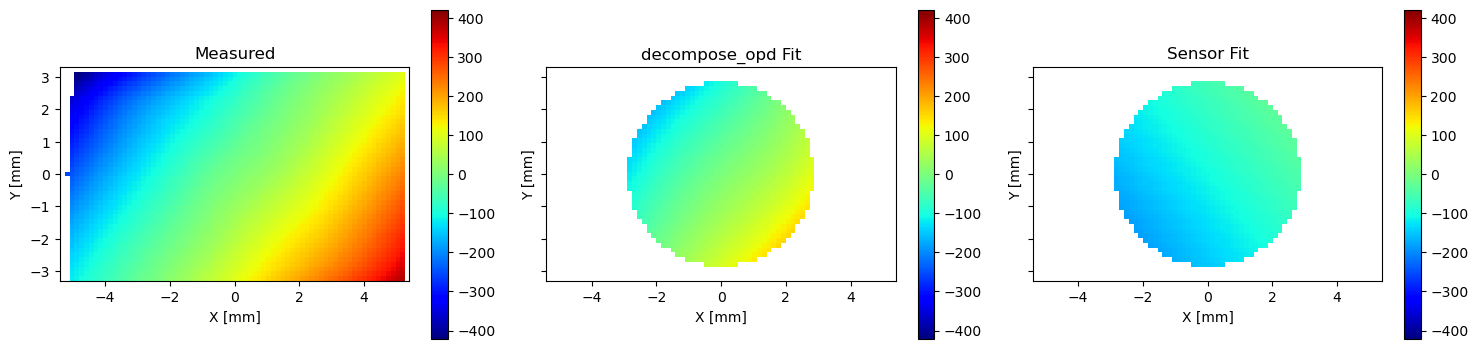

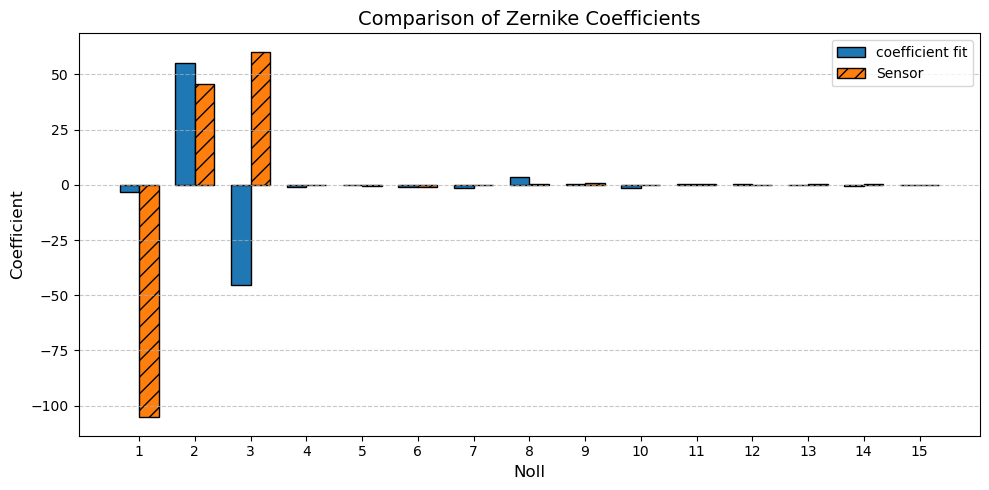

In [ ]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
from poppy.zernike import zernike_basis, decompose_opd

# =============================================================================
# =============================================================================

def parse_beam_center(filename):
    bx = by = None
    with open(filename, 'r', encoding='latin-1') as f:
        for line in f:
            if 'Beam Center X [mm]' in line:
                bx = float(line.split(',')[1])
            elif 'Beam Center Y [mm]' in line:
                by = float(line.split(',')[1])
            if bx is not None and by is not None:
                break
    if bx is None or by is None:
        raise RuntimeError("Beam center not found")
    return bx, by

def parse_wavefront_grid(filename):
    with open(filename, 'r', encoding='latin-1') as f:
        lines = f.readlines()
    idx = next(i for i, L in enumerate(lines) if L.strip().startswith('y / x [mm]'))
    raw_x = lines[idx].split(',')[1:]
    x = np.array([float(t) for t in raw_x if t.strip() and t.strip().lower()!='nan'])
    y, rows = [], []
    for L in lines[idx+1:]:
        if not L.strip() or L.startswith('***'): break
        parts = L.split(',')
        yt = parts[0].strip()
        if not yt or yt.lower()=='nan': continue
        y.append(float(yt))
        row = []
        for v in parts[1:]:
            vc = v.strip()
            row.append(np.nan if (not vc or vc.lower()=='nan') else float(vc))
        if len(row)<len(x): row += [np.nan]*(len(x)-len(row))
        else: row = row[:len(x)]
        rows.append(row)
    return x, np.array(y), np.array(rows)

def parse_zernike_coeffs(filename, n_modes):
    coeffs = []
    in_zfit = False
    pat = re.compile(r'\s*(\d+),\s*-?\d+,\s*-?\d+,\s*([-\d\.eE]+)')
    with open(filename, 'r', encoding='latin-1') as f:
        for line in f:
            if line.strip().startswith('*** ZERNIKE FIT ***'):
                in_zfit = True
                continue
            if in_zfit:
                m = pat.match(line)
                if m:
                    idx, c = int(m.group(1)), float(m.group(2))
                    if idx <= n_modes:
                        coeffs.append(c)
                if len(coeffs) >= n_modes:
                    break
    if len(coeffs) < n_modes:
        raise RuntimeError(f"Expected {n_modes} modes, got {len(coeffs)}")
    return np.array(coeffs)

def noll_to_zernike(j):
    n = 0; j1 = j-1
    while j1 >= n+1:
        n += 1; j1 -= n
    m = -n + 2*j1
    return n, m

# =============================================================================
# Fitting poppy.decompose_opd
# =============================================================================

def builtin_fit_zernikes(wf, mask, n_modes, R, Th):
    coeffs = decompose_opd(wf, aperture=mask, nterms=n_modes,
                           basis=zernike_basis, rho=R, theta=Th)
    basis = zernike_basis(nterms=n_modes, rho=R, theta=Th)
    wf_fit = np.full_like(wf, np.nan)
    wf_fit[mask] = sum(coeffs[j] * basis[j][mask] for j in range(n_modes))
    return coeffs, wf_fit

def sensor_reconstruct(x, y, pupil_d, bx, by, coeffs):
    Xn = (x - bx) / (pupil_d/2)
    Yn = (y - by) / (pupil_d/2)
    Xm, Ym = np.meshgrid(Xn, Yn)
    R = np.hypot(Xm, Ym)
    Th = np.arctan2(Ym, Xm)
    mask = R <= 1
    basis = zernike_basis(nterms=len(coeffs), rho=R, theta=Th)
    wf_fit = np.full_like(R, np.nan)
    wf_fit[mask] = sum(coeffs[j] * basis[j][mask] for j in range(len(coeffs)))
    return wf_fit, R, mask

# =============================================================================
# Main
# =============================================================================

def main():
    
    data_dir       = file
    csv_files      = [f for f in os.listdir(data_dir) if f.endswith('.csv')]
    filename       = os.path.join(data_dir, csv_files[9])
    pupil_diameter = 5.8
    n_modes        = 15

    # parse data
    bx, by          = parse_beam_center(filename)
    x_phys, y_phys, W_phys = parse_wavefront_grid(filename)
    raw_coeffs      = parse_zernike_coeffs(filename, n_modes)

    # swap tip/tilt
    corrected = raw_coeffs.copy()
    corrected[1], corrected[2] = raw_coeffs[2], raw_coeffs[1]

    #normalize for poppy basis
    poppy_coeffs = []
    for j, c in enumerate(corrected, start=1):
        n, m = noll_to_zernike(j)
        norm = np.sqrt(n+1) if m==0 else np.sqrt(2*(n+1))
        poppy_coeffs.append(c / norm)
    poppy_coeffs = np.array(poppy_coeffs)

    #fit
    Xn = (x_phys - bx)/(pupil_diameter/2)
    Yn = (y_phys - by)/(pupil_diameter/2)
    Xm, Ym = np.meshgrid(Xn, Yn)
    R  = np.hypot(Xm, Ym)
    Th = np.arctan2(Ym, Xm)
    mask = R <= 1

    b_coeffs, W_builtin = builtin_fit_zernikes(W_phys, mask, n_modes, R, Th)

    #sensor reconstruction
    W_sensor, _, _ = sensor_reconstruct(
        x_phys, y_phys, pupil_diameter, bx, by, poppy_coeffs
    )

    # --- RMS errors ---
    rms = lambda A,B: np.sqrt(np.nanmean((A[mask] - B[mask])**2))
    print(f"RMS decompose_opd vs measured: {rms(W_builtin, W_phys):.3f} µm")
    print(f"RMS sensor vs measured:        {rms(W_sensor, W_phys):.3f} µm")

    # --- plot maps ---
    extent = [x_phys.min(), x_phys.max(), y_phys.min(), y_phys.max()]
    titles = ['Measured', 'decompose_opd Fit', 'Sensor Fit']
    maps   = [W_phys, W_builtin, W_sensor]
    fig, axs = plt.subplots(1,3,figsize=(15,5), sharex=True, sharey=True)
    vlim = np.nanmax(np.abs(W_phys))
    for ax, W, t in zip(axs, maps, titles):
        im = ax.imshow(W, extent=extent, origin='upper',
                       cmap='jet', vmin=-vlim, vmax=vlim)
        ax.set_title(t); ax.set_xlabel('X [mm]'); ax.set_ylabel('Y [mm]')
        fig.colorbar(im, ax=ax, shrink=0.7)
    plt.tight_layout()
    plt.show()

    # --- clearer coefficient bar chart ---
    modes = np.arange(1, n_modes+1)
    width = 0.35

    fig, ax = plt.subplots(figsize=(10, 5))
    bars1 = ax.bar(modes - width/2, b_coeffs, width,
                   label='coefficient fit', edgecolor='black')
    bars2 = ax.bar(modes + width/2, raw_coeffs, width,
                   label='Sensor', edgecolor='black', hatch='//')


if __name__ == '__main__':
    main()


# Zernike fit C


--- Diagnostica confronto coefficiente Zernike ---
Modo | Poppy coeff. | Sensor coeff. |  Diff coeff.
------------------------------------------------
   1 |      0.00000 |      0.00000 |      0.00000
   2 |      0.00000 |      0.00000 |      0.00000
   3 |      0.00000 |      0.00000 |      0.00000
   4 |     -0.99936 |      0.01388 |     -1.01324
   5 |     -0.27800 |     -0.40645 |      0.12846
   6 |     -1.04240 |     -0.37926 |     -0.66314
   7 |     -1.51418 |     -0.09051 |     -1.42367
   8 |      3.51895 |      0.10182 |      3.41712
   9 |      0.21707 |      0.24395 |     -0.02688
  10 |     -1.35399 |     -0.07425 |     -1.27974
  11 |      0.51590 |      0.04965 |      0.46625
  12 |      0.43323 |     -0.03036 |      0.46359
  13 |     -0.11123 |      0.10688 |     -0.21811
  14 |     -0.59377 |      0.09835 |     -0.69212
  15 |     -0.26115 |     -0.07937 |     -0.18178

--- RMS errore ricostruzione singoli modi ---
Modo  1: RMS errore singolo = 71.1773 µm
Modo  2: R

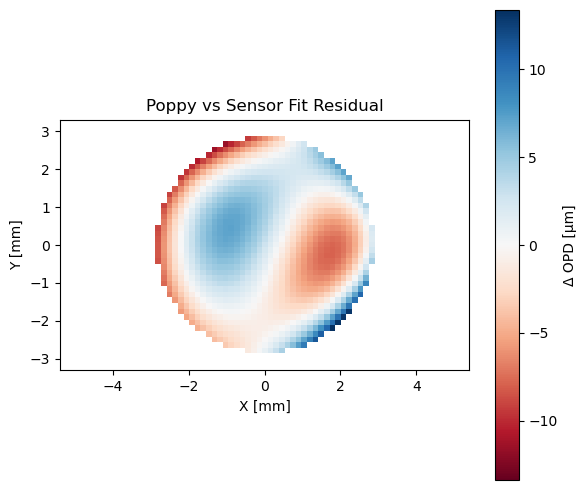

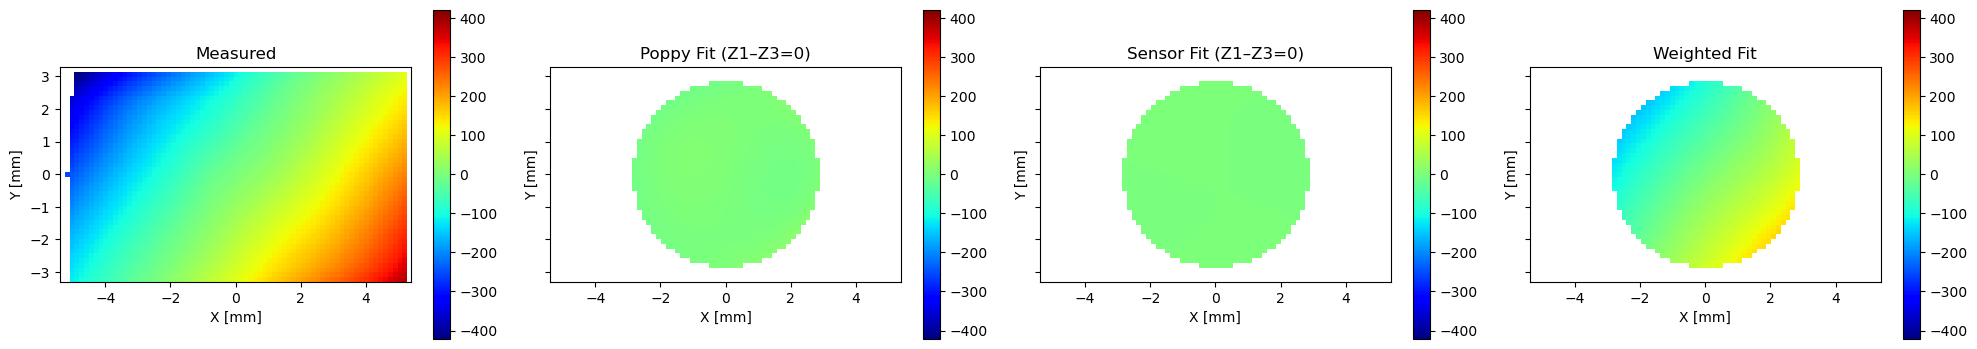

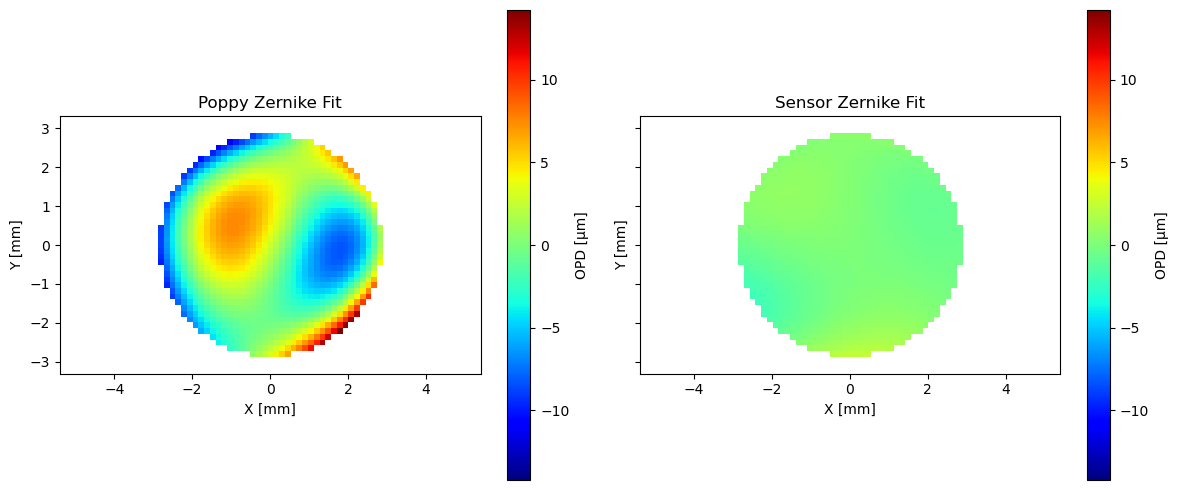

RMS difference between sensor and poppy fit: 4.2651 µm


In [ ]:
import os, re
import numpy as np
import matplotlib.pyplot as plt
from poppy.zernike import zernike_basis, decompose_opd

# — CSV parsing —

def parse_beam_center(fn):
    bx = by = None
    with open(fn, 'r', encoding='latin-1') as f:
        for L in f:
            if 'Beam Center X [mm]' in L:
                bx = float(L.split(',')[1])
            elif 'Beam Center Y [mm]' in L:
                by = float(L.split(',')[1])
            if bx is not None and by is not None:
                break
    if bx is None or by is None:
        raise RuntimeError("Beam center not found")
    return bx, by

def parse_wavefront_grid(fn):
    with open(fn,'r',encoding='latin-1') as f:
        lines = f.readlines()
    idx = next(i for i,L in enumerate(lines) if L.strip().startswith('y / x [mm]'))
    raw_x = lines[idx].split(',')[1:]
    x = np.array([float(t) for t in raw_x if t.strip() and t.strip().lower()!='nan'])
    y, rows = [], []
    for L in lines[idx+1:]:
        if not L.strip() or L.startswith('***'):
            break
        p = L.split(','); yt = p[0].strip()
        if yt and yt.lower()!='nan':
            y.append(float(yt))
            vals = []
            for v in p[1:]:
                vc = v.strip()
                vals.append(np.nan if not vc or vc.lower()=='nan' else float(vc))
            if len(vals) < len(x):
                vals += [np.nan]*(len(x)-len(vals))
            else:
                vals = vals[:len(x)]
            rows.append(vals)
    return x, np.array(y), np.array(rows)

def parse_zernike_coeffs(fn, n_modes):
    coeffs = []
    in_z = False
    pat = re.compile(r'\s*(\d+),\s*-?\d+,\s*-?\d+,\s*([-\d\.eE]+)')
    with open(fn, 'r', encoding='latin-1') as f:
        for L in f:
            if L.strip().startswith('*** ZERNIKE FIT ***'):
                in_z = True
                continue
            if in_z:
                m = pat.match(L)
                if m:
                    idx, c = int(m.group(1)), float(m.group(2))
                    if idx <= n_modes:
                        coeffs.append(c)
                if len(coeffs) >= n_modes:
                    break
    return np.array(coeffs)

def noll_to_zernike(j):
    n = 0; j1 = j - 1
    while j1 >= n+1:
        n += 1; j1 -= n
    m = -n + 2*j1
    return n, m

def remap_sensor_coeffs(raw, n_modes):
    rem = np.zeros(n_modes)
    for i, c in enumerate(raw, start=1):
        tgt = {2:3, 3:2}.get(i, i)
        if tgt <= n_modes:
            rem[tgt-1] = c
    return rem

def normalize_sensor_coeffs(raw):
    rem = remap_sensor_coeffs(raw, len(raw))
    poppy = []
    for j, c in enumerate(rem, start=1):
        n, m = noll_to_zernike(j)
        norm = np.sqrt(n+1) if m == 0 else np.sqrt(2*(n+1))
        poppy.append(c / norm)
    return np.array(poppy)

# — Fits
def builtin_fit(wf, mask, n_modes, R, Th):
    coeffs = decompose_opd(wf, aperture=mask, nterms=n_modes,
                          basis=zernike_basis, rho=R, theta=Th)
    basis = zernike_basis(nterms=n_modes, rho=R, theta=Th)
    wf_fit = np.full_like(wf, np.nan)
    wf_fit[mask] = sum(coeffs[j] * basis[j][mask] for j in range(n_modes))
    return np.array(coeffs), wf_fit

def sensor_reconstruct(x, y, pd, bx, by, coeffs):
    Xn = (x - bx) / (pd/2)
    Yn = (y - by) / (pd/2)
    Xm, Ym = np.meshgrid(Xn, Yn)
    R = np.hypot(Xm, Ym)
    Th = np.arctan2(Ym, Xm)
    mask = R <= 1
    basis = zernike_basis(nterms=len(coeffs), rho=R, theta=Th)
    wf = np.full_like(R, np.nan)
    wf[mask] = sum(coeffs[j] * basis[j][mask] for j in range(len(coeffs)))
    return wf, R, mask


def diagnostic_report(b_coeffs, poppy_coeffs, basis, mask, W_phys):
    n_modes = len(b_coeffs)
    print("\n--- Diagnostica confronto coefficiente Zernike ---")
    print(f"{'Modo':>4s} | {'Poppy coeff.':>12s} | {'Sensor coeff.':>12s} | {'Diff coeff.':>12s}")
    print("-" * 48)
    for j in range(n_modes):
        diff = b_coeffs[j] - poppy_coeffs[j]
        print(f"{j+1:4d} | {b_coeffs[j]:12.5f} | {poppy_coeffs[j]:12.5f} | {diff:12.5f}")

    # Ricostruisci ricostruzioni base per base per ogni coefficiente singolo
    print("\n--- RMS errore ricostruzione singoli modi ---")
    for j in range(n_modes):
        W_single = np.full_like(W_phys, np.nan)
        W_single[mask] = b_coeffs[j] * basis[j][mask]
        rms_single = np.sqrt(np.nanmean((W_phys[mask] - W_single[mask])**2))
        print(f"Modo {j+1:2d}: RMS errore singolo = {rms_single:.4f} µm")

    # Ricostruzione totale e RMS tra POPPY e sensore
    W_poppy = np.full_like(W_phys, np.nan)
    W_sensor = np.full_like(W_phys, np.nan)
    W_poppy[mask] = sum(b_coeffs[j] * basis[j][mask] for j in range(n_modes))
    W_sensor[mask] = sum(poppy_coeffs[j] * basis[j][mask] for j in range(n_modes))
    rms_total = np.sqrt(np.nanmean((W_poppy[mask] - W_sensor[mask])**2))
    print(f"\nRMS differenza totale tra ricostruzioni POPPY e Sensor: {rms_total:.4f} µm")

    # RMS rispetto al segnale misurato
    rms_poppy_vs_meas = np.sqrt(np.nanmean((W_poppy[mask] - W_phys[mask])**2))
    rms_sensor_vs_meas = np.sqrt(np.nanmean((W_sensor[mask] - W_phys[mask])**2))
    print(f"RMS POPPY vs misurato: {rms_poppy_vs_meas:.4f} µm")
    print(f"RMS Sensor vs misurato: {rms_sensor_vs_meas:.4f} µm")
    
    
    
    
# — Main —

def main():
    
    directory = r"C:\Users\buonc\OneDrive - Alma Mater Studiorum Università di Bologna\Documents\Astrophysics and Cosmology\TESI\dati_WFS\febbraio\Seginus"
    files = [f for f in os.listdir(directory) if f.endswith('.csv')]
    if not files:
        raise FileNotFoundError("No CSV files found in directory")
   
    filename = files[9]
    full_path = os.path.join(directory, filename)

    pupil_diameter = 5.8  # mm
    n_modes        = 15

   
    bx, by             = parse_beam_center(full_path)
    x_phys, y_phys, W_phys = parse_wavefront_grid(full_path)
    raw_coeffs         = parse_zernike_coeffs(full_path, n_modes)

    # — Sensor coeffs: remap, normalize
    poppy_coeffs = normalize_sensor_coeffs(raw_coeffs)
    poppy_coeffs = np.array(poppy_coeffs)
    #poppy_coeffs = remap_sensor_coeffs(raw_coeffs, n_modes)
    poppy_coeffs[:3] = 0.0
  


    # maschera circolare di raggio unitario
    Xn = (x_phys - bx) / (pupil_diameter/2)
    Yn = (y_phys - by) / (pupil_diameter/2)
    Xm, Ym = np.meshgrid(Xn, Yn)
    R = np.hypot(Xm, Ym)
    Th = np.arctan2(Ym, Xm)
    mask = R <= 1

    # decompose_opd fit
    b_coeffs, W_builtin = builtin_fit(W_phys, mask, n_modes, R, Th)
    b_coeffs[:3] = 0.0
    basis = zernike_basis(nterms=n_modes, rho=R, theta=Th)
    W_builtin_z = np.full_like(W_phys, np.nan)
    W_builtin_z[mask] = sum(b_coeffs[j] * basis[j][mask] for j in range(n_modes))

    diagnostic_report(b_coeffs, poppy_coeffs, basis, mask, W_phys)
    
    # Sensor reconstruction 
    W_sensor_z, _, _ = sensor_reconstruct(
        x_phys, y_phys, pupil_diameter, bx, by, poppy_coeffs
    )


    print(f"Comparing Zernike coefficients (Mode 1…{n_modes}):")
    for j in range(n_modes):
        print(f" Mode {j+1:2d}: poppy={b_coeffs[j]:7.3f}, sensor={poppy_coeffs[j]:7.3f}")


    apod = np.clip(1 - (R/1.0)**10, 0, 1)
    Zmat = np.vstack([basis[j][mask] for j in range(n_modes)]).T
    wf_vec = W_phys[mask]
    w = apod[mask]
    Zw, Ww = Zmat*w[:,None], wf_vec*w
    coeffs_w, *_ = np.linalg.lstsq(Zw, Ww, rcond=None)
    W_weighted = np.full_like(W_phys, np.nan)
    W_weighted[mask] = sum(coeffs_w[j] * basis[j][mask] for j in range(n_modes))
    rms_w = np.sqrt(np.nanmean((W_weighted[mask] - W_phys[mask])**2))
    print(f"\nWeighted fit RMS vs measured: {rms_w:.4f} µm")

 
    diff = W_builtin_z - W_sensor_z
    plt.figure(figsize=(6,5))
    plt.imshow(diff, extent=[x_phys.min(), x_phys.max(), y_phys.min(), y_phys.max()],
               origin='upper', cmap='RdBu', vmin=-np.nanmax(np.abs(diff)), vmax=np.nanmax(np.abs(diff)))
    plt.colorbar(label='Δ OPD [µm]')
    plt.title('Poppy vs Sensor Fit Residual')
    plt.xlabel('X [mm]'); plt.ylabel('Y [mm]')
    plt.tight_layout(); plt.show()

  
    #resid = W_builtin_z - W_phys
    #plt.figure(figsize=(6,4))
    #plt.hist(resid[mask].ravel(), bins=100, edgecolor='black')
    #plt.xlabel('Residual OPD [µm]'); plt.ylabel('Count')
    #plt.title('Residuals after removing Z₁–Z₃')
    #plt.grid(alpha=0.6); plt.show()

    # — Side‐by‐side OPD maps —
    extent = [x_phys.min(), x_phys.max(), y_phys.min(), y_phys.max()]
    titles = ['Measured', 'Poppy Fit (Z1–Z3=0)', 'Sensor Fit (Z1–Z3=0)', 'Weighted Fit']
    maps   = [W_phys, W_builtin_z, W_sensor_z, W_weighted]
    fig, axs = plt.subplots(1, 4, figsize=(20,5), sharex=True, sharey=True)
    vlim = np.nanmax(np.abs(W_phys))
    for ax, W, t in zip(axs, maps, titles):
        im = ax.imshow(W, extent=extent, origin='upper', cmap='jet', vmin=-vlim, vmax=vlim)
        ax.set_title(t); ax.set_xlabel('X [mm]'); ax.set_ylabel('Y [mm]')
        fig.colorbar(im, ax=ax, shrink=0.7)
    plt.tight_layout(); plt.show()
    

    
    extent = [x_phys.min(), x_phys.max(), y_phys.min(), y_phys.max()]
    fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)
    vlim_zern = max(np.nanmax(np.abs(W_builtin_z)), np.nanmax(np.abs(W_sensor_z)))
    for ax, W, title in zip(
        axs,
        [W_builtin_z, W_sensor_z],
        ['Poppy Zernike Fit', 'Sensor Zernike Fit']
    ):
        im = ax.imshow(
            W, extent=extent, origin='upper',
            cmap='jet', vmin=-vlim_zern, vmax=vlim_zern
        )
        ax.set_title(title, fontsize=12)
        ax.set_xlabel('X [mm]')
        ax.set_ylabel('Y [mm]')
        plt.colorbar(im, ax=ax, label='OPD [µm]')
    plt.tight_layout()
    plt.show()

    rms_diff = np.sqrt(np.nanmean((W_sensor_z - W_builtin_z)**2))
    print(f"RMS difference between sensor and poppy fit: {rms_diff:.4f} µm")
    



if __name__ == '__main__':
    main()


